In [2]:
import numpy as np
import matplotlib.pyplot as plt

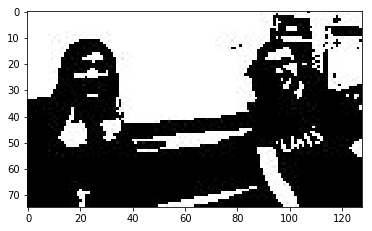

In [3]:
img = plt.imread('MLSquadBW.jpg')
plt.imshow(img, cmap = "gray")
plt.show()

In [4]:
class NoisyImages(object):
    def __init__(self, prop, varSigma):
        self.prop = prop
        self.varSigma = varSigma
        
    def addGaussianNoise(self, im):
        im = im/255
        N = int(np.round(np.prod(im.shape)*self.prop))
        index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
        e = self.varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
        im2 = np.copy(im).astype('float')
        im2[index] += e[index]
        return im2
    
    def addSaltnPepperNoise(self, im):
        im = im/255
        N = int(np.round(np.prod(im.shape)*self.prop))
        index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
        im2 = np.copy(im)
        im2[index] = 1-im2[index]
        return im2
    

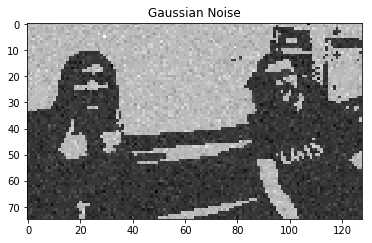

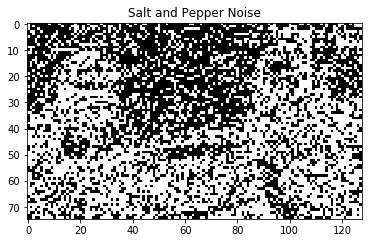

In [5]:
createNoise = NoisyImages(0.7, 0.1)

gaussianImg = createNoise.addGaussianNoise(img)
snpImg = createNoise.addSaltnPepperNoise(img)

plt.imshow(gaussianImg, cmap="gray")
plt.title("Gaussian Noise")
plt.show()

plt.imshow(snpImg, cmap="gray")
plt.title("Salt and Pepper Noise")
plt.show()

In [6]:
class HelperTools(object):    
    def neighbours(self, i, j, M, N, size=4):
        # M = size of rows (ie x), N = size of columns (ie y)
        if size == 4:
            if i == 0 and j == 0:
                n = [(0, 1), (1, 0)]
            elif i == 0 and j==N-1:
                n = [(0, N-2), (1, N-1)]
            elif i == M-1 and j == 0:
                n = [(M-1, 1), (M-2, 0)]
            elif i == M-1 and j == N-1:
                n = [(M-1, N-2), (M-2, N-1)]
            elif i == 0:
                n = [(0, j-1), (0, j+1), (1, j)]
            elif i == M-1:
                n = [(M-1, j-1), (M-1, j+1), (M-2, j)]
            elif j == 0:
                n = [(i-1, 0), (i+1, 0), (i, 1)]
            elif j == N-1:
                n = [(i-1, N-1), (i+1, N-1), (i, N-2)]
            else:
                n = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
                
        if size == 8:
            if i == 0 and j == 0:
                n = [(0, 1), (1, 0), (1, 1)]
            elif i == 0 and j == N-1:
                n = [(0, N-2), (1, N-1), (1, N-2)]
            elif i == M-1 and j == 0:
                n = [(M-1, 1), (M-2, 0), (M-2, 1)]
            elif i == M-1 and j == N-1:
                n = [(M-1, N-2), (M-2, N-1), (M-2, N-2)]
            elif i == 0:
                n = [(0, j-1), (0, j+1), (1, j), (1, j+1), (1, j-1)]
            elif i == M-1:
                n = [(M-1, j-1), (M-1, j+1), (M-2, j), (M-2, j+1), (M-2, j-1)]
            elif j == 0:
                n = [(i-1, 0), (i+1, 0), (i, 1), (i+1, 1), (i-1, 1)]
            elif j == N-1:
                n = [(i-1, N-1), (i+1, N-1), (i, N-2), (i+1, N-2), (i-1, N-2)]
            else:
                n = [(i-1, j), (i+1, j), (i, j-1), (i, j+1), (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
            
        return n

In [18]:
class ICM(object):
    def __init__(self, image):
        # Rounds values in the y image to be 0 and 1
        self.image = (image > 0.5).astype(float)
        
        #Stuff to help calculate loops and neighbours
        self.T = image.shape[0]
        self.N = image.shape[1]
        self.helper = HelperTools()
        
        # Set x to be the image and both images
        self.x = self.image + (self.image - 1)
        self.image = self.image + (self.image -1)
    
    def e0(self, t, i, calcZ=False):
        ni = self.helper.neighbours(t, i, self.T, self.N, 8)
        w = 1/8
        
        # Runs when we want to find the Z0 value
        if calcZ:
            out1 = 0
            out2 = 0
            for j in ni:
                out1 += w*1*(self.x[j[0]][j[1]])
                out2 += w*-1*(self.x[j[0]][j[1]])
                
            return np.exp(out1) + np.exp(out2)
        
        # Runs when we want to find the normal E0 value
        out = 0
        for j in ni:
            out += w*(self.x[t][i])*(self.x[j[0]][j[1]])
        return out
    
    def lixi(self, t, i):
        """Returns 2.1 if values are the same, -2.1 otherwise"""
        cons = 2.1
        return cons * self.x[t][i] * self.image[t][i]
        
    def prodfunc(self, x, y, Z1, xiVal):
        """The joint probability distribution function"""
        Z0 = self.e0(x, y, True)
        
        initx = self.x[x][y]
        self.x[x][y] = xiVal
        
        prodOutput = (1/Z1) * np.exp(self.lixi(x, y)) * (1/Z0) * np.exp(self.e0(x, y))
        
        self.x[x][y] = initx
        
        return prodOutput
        
    def runICMloop(self):
        """Runs ICM once"""
        change = False
        
        Z1 = np.exp(2.1) + np.exp(-2.1)
        retImg = []
        for t in range(self.T):
            row = []
            for i in range(self.N):
                if self.prodfunc(t, i, Z1, 1) >  self.prodfunc(t, i, Z1, -1):
                    if self.x[t][i] == -1:
                        change = True
                    output = 1
                else:
                    if self.x[t][i] == 1:
                        change = True
                    output = -1
                    
                row.append(output)
            retImg.append(row)
            
        self.x = retImg
                
        return retImg, change
    
    def runICM(self, maxIters=100):
        """Runs ICM many times"""
        change = True
        count = 0
        while change == True and count < maxIters:
            retImg, change = self.runICMloop()
            count += 1
        
        print(count)
            
        return retImg

1


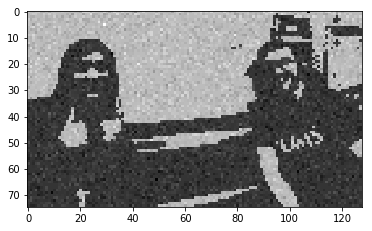

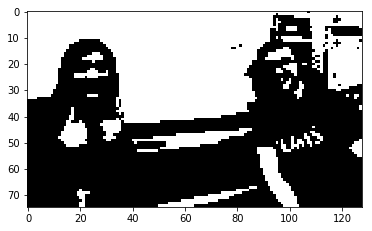

In [19]:
ICMdoer = ICM(gaussianImg)
output = ICMdoer.runICM(50)
plt.imshow(gaussianImg, cmap="gray")
plt.show()
plt.imshow(output, cmap="gray")
plt.show()

1


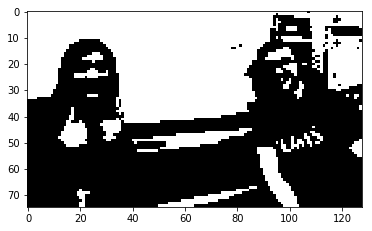

In [20]:
output2 = ICMdoer.runICM(1)
plt.imshow(output2, cmap="gray")
plt.show()

1
1


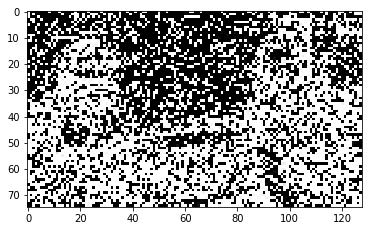

iters: 1


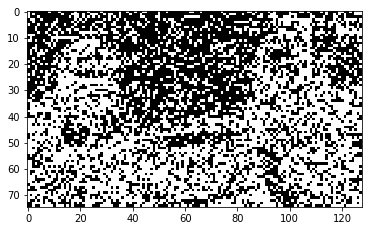

iters: 50


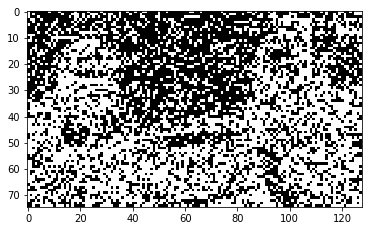

In [22]:
ICMdoer = ICM(snpImg)
output = ICMdoer.runICM()
output2 = ICMdoer.runICM(50)
plt.imshow(snpImg, cmap="gray")
plt.show()
print("iters: 1")
plt.imshow(output, cmap="gray")
plt.show()
print("iters: 50")
plt.imshow(output2, cmap="gray")
plt.show()


In [41]:
class Gibbs(object):
    def __init__(self, image):
        # Rounds values in the y image to be 0 and 1
        self.image = (image > 0.5).astype(float)
        
        #Stuff to help calculate loops and neighbours
        self.T = image.shape[0] #cols 75
        self.N = image.shape[1] #rows 128
        self.helper = HelperTools()
        
        # Set x to be the image and both images. Convert zeroes to -1s.
        self.x = self.image + (self.image - 1)
        self.image = self.image + (self.image -1)
    
    def condProb(self, t, i, x):
        """Returns 2.1 if values are the same, -2.1 otherwise"""
        y = self.image[t][i]
        cons = 2.1
        similarity = cons * x * y
        
        #normalises similarity to a prob by dividing it by the range of values similarity could be
        prob = np.exp(similarity)/(np.exp(2.1) + np.exp(-2.1))  
        
        return prob
        
    def jointProb(self, t, i, x):
        ni = self.helper.neighbours(t, i, self.T, self.N, 8)
        w = 1/8
        
        out1 = 0
        out2 = 0
        for j in ni:
            out1 += w*1*(self.x[j[0]][j[1]])
            out2 += w*-1*(self.x[j[0]][j[1]])

        z0 = np.exp(out1) + np.exp(out2)
        
        # Runs when we want to find the normal E0 value
        out = 0
        for j in ni:
            out += w*(x)*(self.x[j[0]][j[1]])
        return np.exp(out)/z0
        
    def findProb(self, t, i):
        topVal = self.condProb(t, i, 1) * self.jointProb(t, i, 1)
        bottomVal = (self.condProb(t, i, 1) * self.jointProb(t, i, 1)) + (self.condProb(t, i, -1) * self.jointProb(t, i, -1))
        return topVal/bottomVal
        
    def runGibbsLoop(self, iterations=100, randomise=False, samples=20):
        if randomise:
            np.random.seed(42)
            ts = np.random.randint(0, self.T, samples) 
            ns = np.random.randint(0, self.N, samples)   
            print("Finished randomising samples")
        else:
            ts = range (self.T)
            ns = range (self.N)
            
        points = []
        for i in range(samples):
            points.append((ts[i], ns[i]))
            
        for tau in range (iterations):
            print("Iteration: ", tau)
            for (t, i) in points:
                probI = self.findProb(t, i)

                #select uniform z
                uniformDist = np.random.uniform(0, 1, 1)

                if probI > uniformDist: 
                    self.x[t][i] = 1
                else:
                    self.x[t][i] = -1
        return self.x

        

In [42]:
gaussianImgs = []
snpImgs = []
for i in range(10):
    for j in range(10):
        createNoise = NoisyImages(i/10, j/10)
        gaussianImgs.append((createNoise.addGaussianNoise(img), i/10, j/10))
        snpImgs.append((createNoise.addSaltnPepperNoise(img), i/10, j/10))

prop: 0.0 	varSigma: 0.0
Original


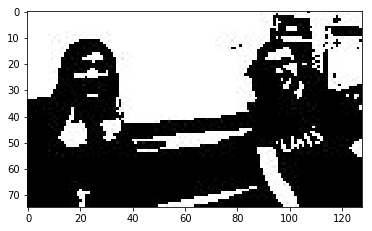

Gaussian


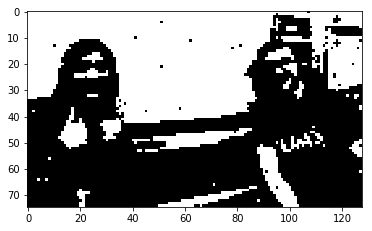

Salt and Pepper


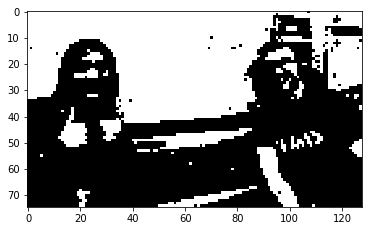



prop: 0.0 	varSigma: 0.1
Original


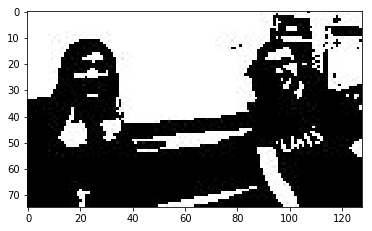

Gaussian


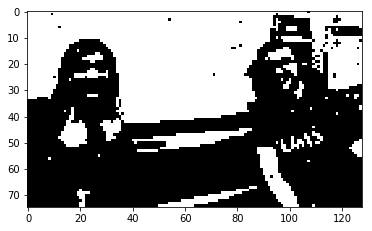

Salt and Pepper


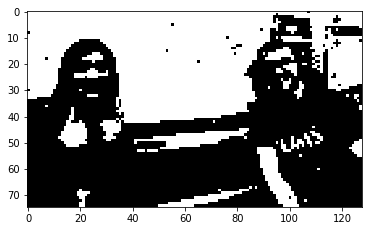



prop: 0.0 	varSigma: 0.2
Original


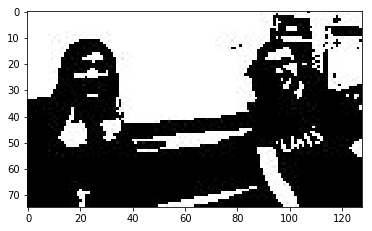

Gaussian


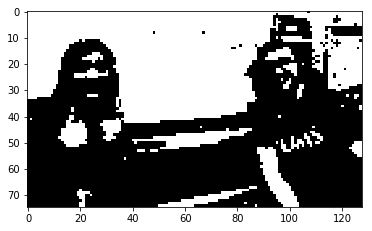

Salt and Pepper


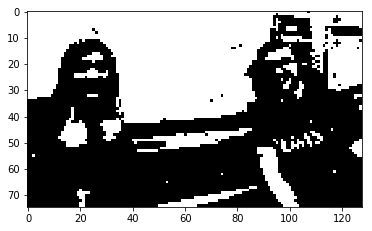



prop: 0.0 	varSigma: 0.3
Original


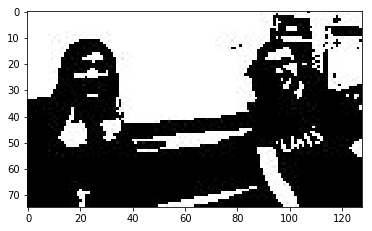

Gaussian


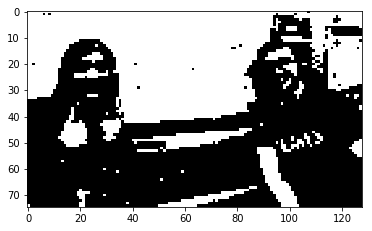

Salt and Pepper


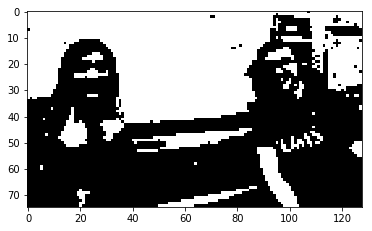



prop: 0.0 	varSigma: 0.4
Original


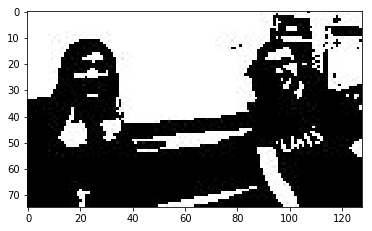

Gaussian


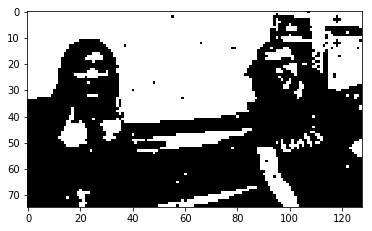

Salt and Pepper


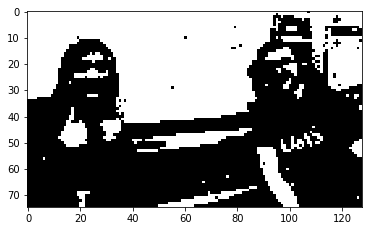



prop: 0.0 	varSigma: 0.5
Original


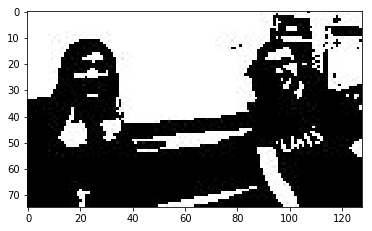

Gaussian


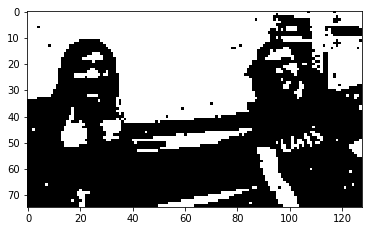

Salt and Pepper


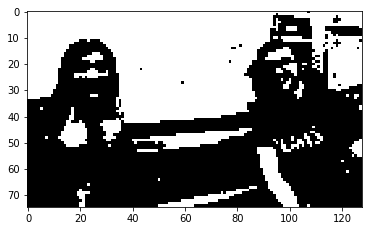



prop: 0.0 	varSigma: 0.6
Original


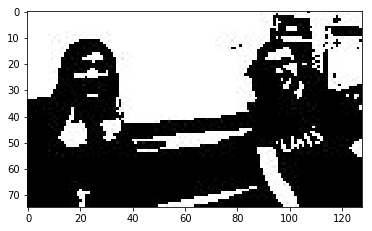

Gaussian


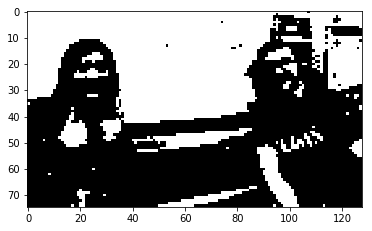

Salt and Pepper


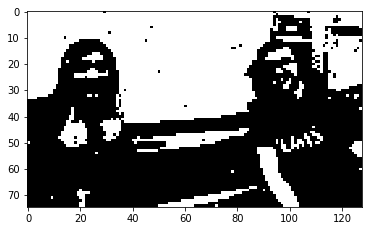



prop: 0.0 	varSigma: 0.7
Original


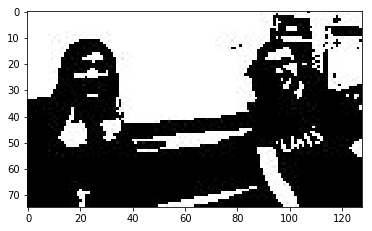

Gaussian


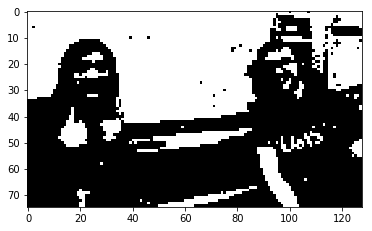

Salt and Pepper


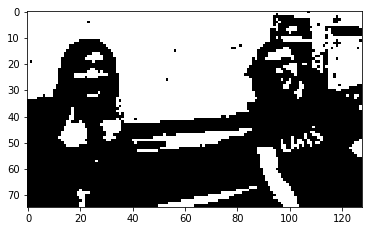



prop: 0.0 	varSigma: 0.8
Original


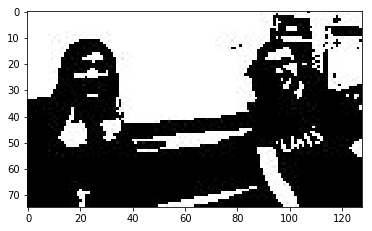

Gaussian


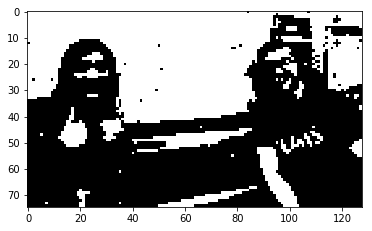

Salt and Pepper


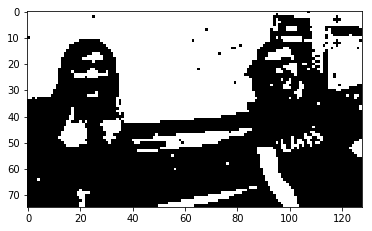



prop: 0.0 	varSigma: 0.9
Original


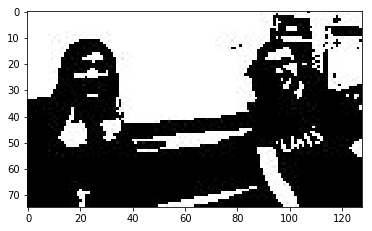

Gaussian


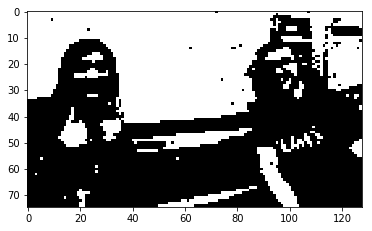

Salt and Pepper


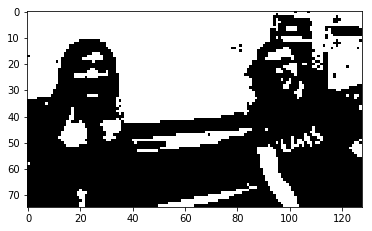



prop: 0.1 	varSigma: 0.0
Original


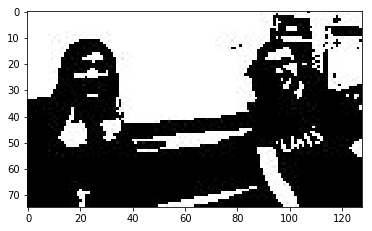

Gaussian


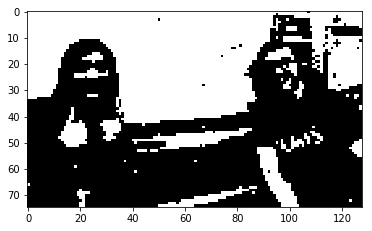

Salt and Pepper


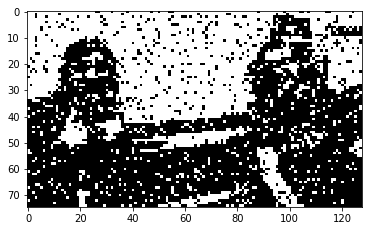



prop: 0.1 	varSigma: 0.1
Original


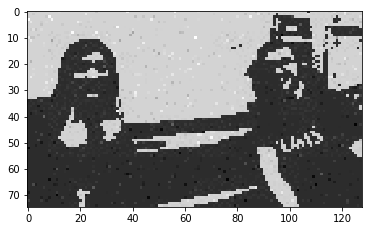

Gaussian


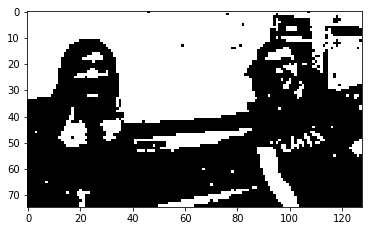

Salt and Pepper


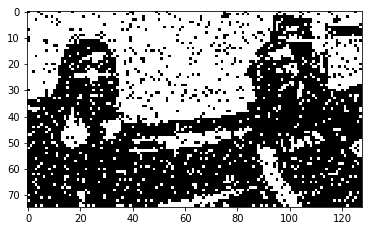



prop: 0.1 	varSigma: 0.2
Original


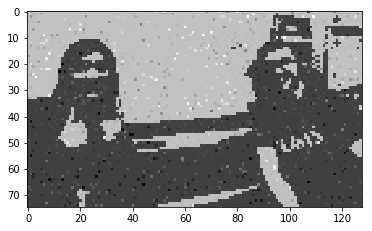

Gaussian


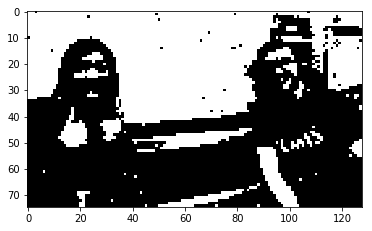

Salt and Pepper


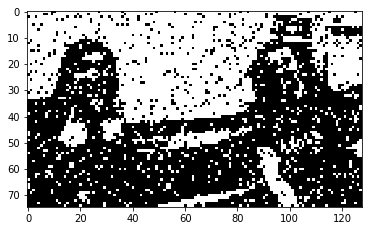



prop: 0.1 	varSigma: 0.3
Original


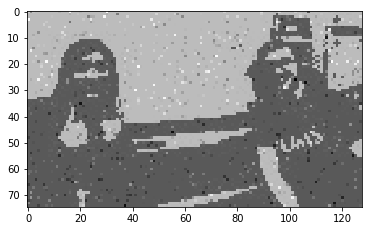

Gaussian


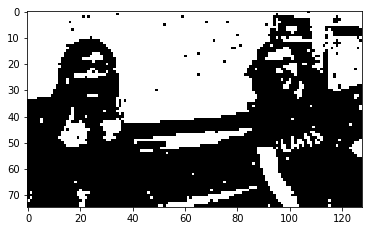

Salt and Pepper


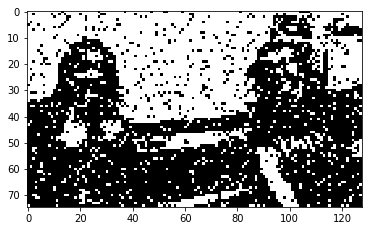



prop: 0.1 	varSigma: 0.4
Original


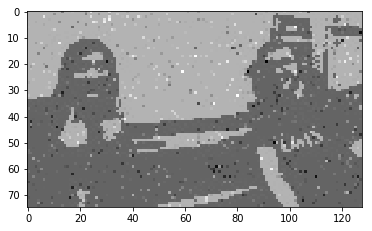

Gaussian


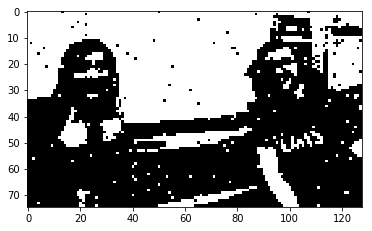

Salt and Pepper


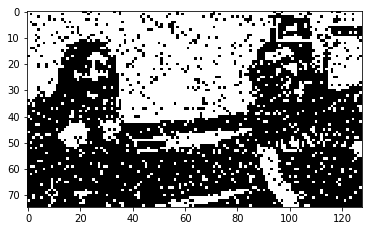



prop: 0.1 	varSigma: 0.5
Original


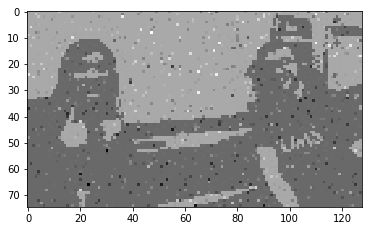

Gaussian


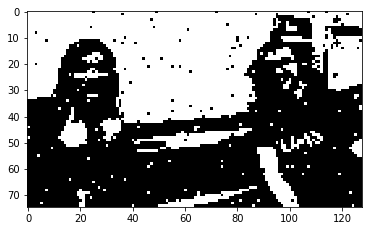

Salt and Pepper


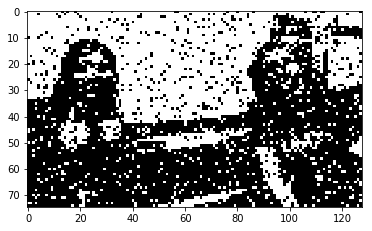



prop: 0.1 	varSigma: 0.6
Original


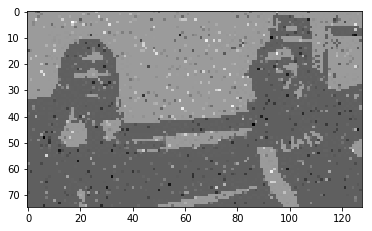

Gaussian


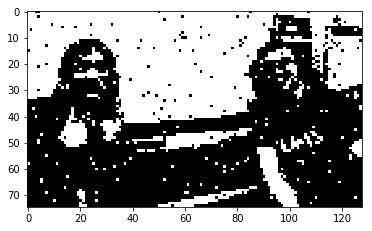

Salt and Pepper


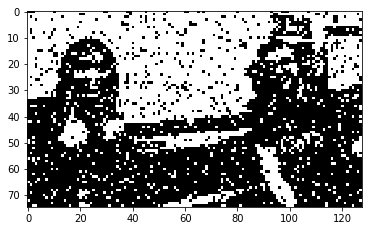



prop: 0.1 	varSigma: 0.7
Original


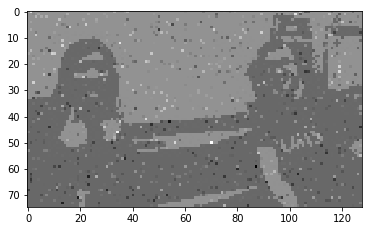

Gaussian


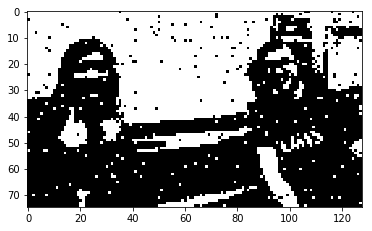

Salt and Pepper


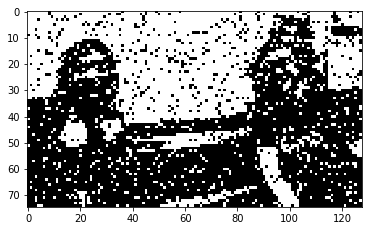



prop: 0.1 	varSigma: 0.8
Original


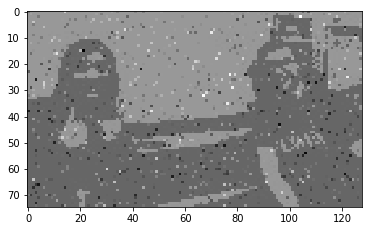

Gaussian


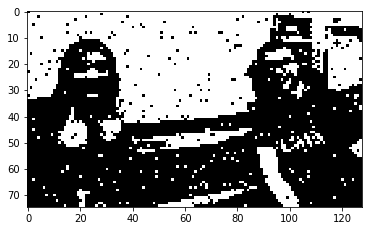

Salt and Pepper


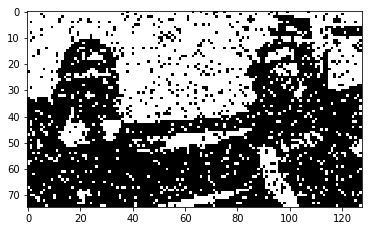



prop: 0.1 	varSigma: 0.9
Original


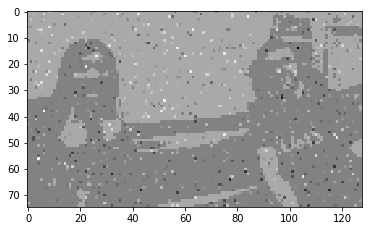

Gaussian


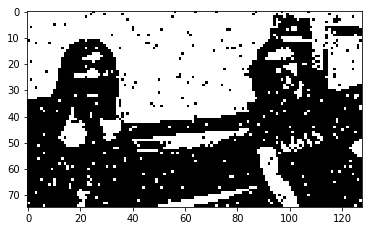

Salt and Pepper


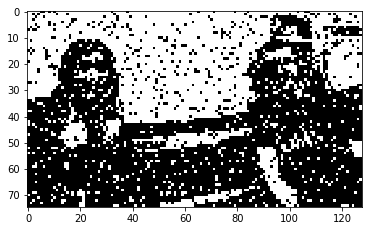



prop: 0.2 	varSigma: 0.0
Original


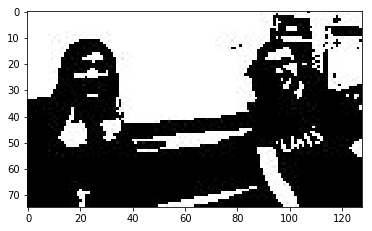

Gaussian


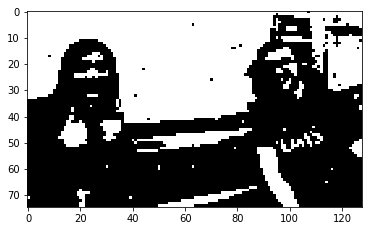

Salt and Pepper


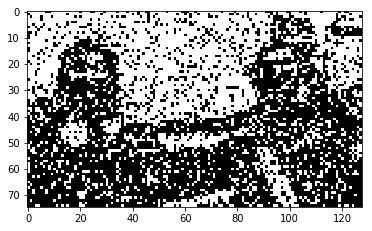



prop: 0.2 	varSigma: 0.1
Original


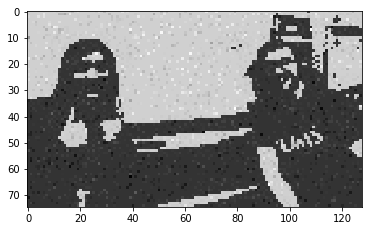

Gaussian


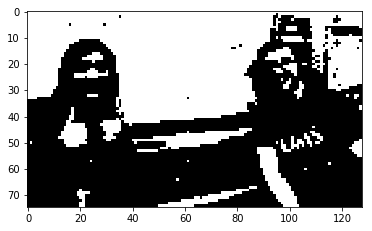

Salt and Pepper


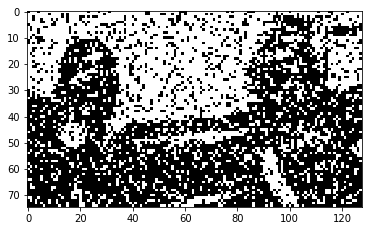



prop: 0.2 	varSigma: 0.2
Original


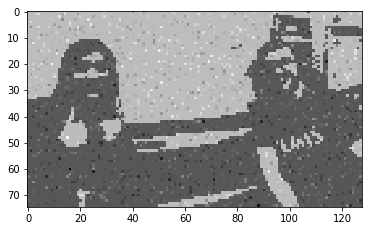

Gaussian


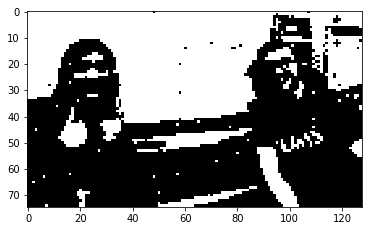

Salt and Pepper


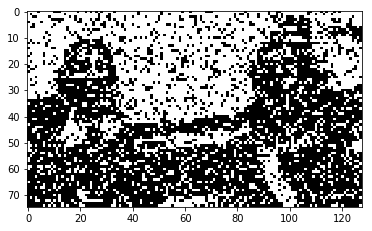



prop: 0.2 	varSigma: 0.3
Original


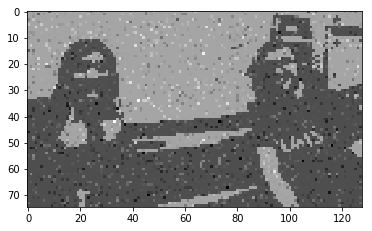

Gaussian


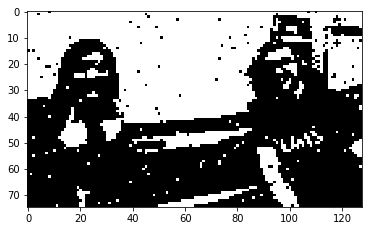

Salt and Pepper


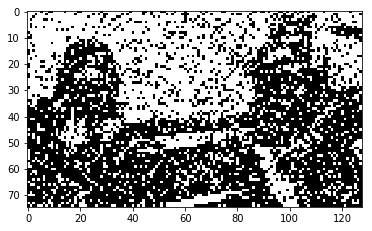



prop: 0.2 	varSigma: 0.4
Original


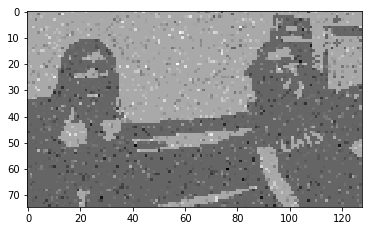

Gaussian


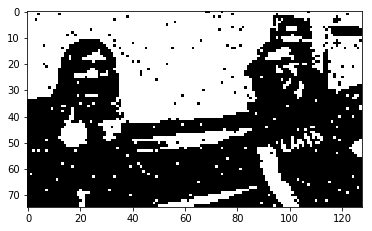

Salt and Pepper


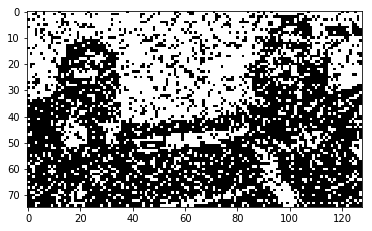



prop: 0.2 	varSigma: 0.5
Original


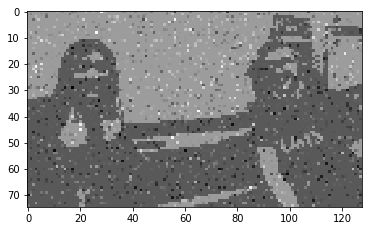

Gaussian


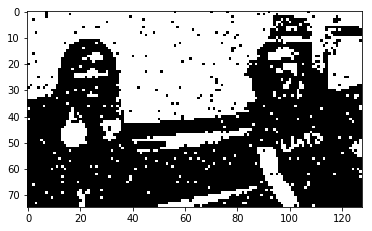

Salt and Pepper


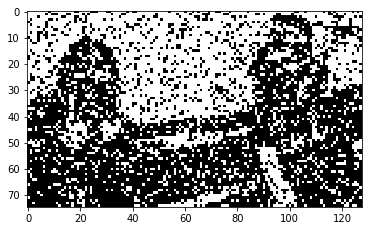



prop: 0.2 	varSigma: 0.6
Original


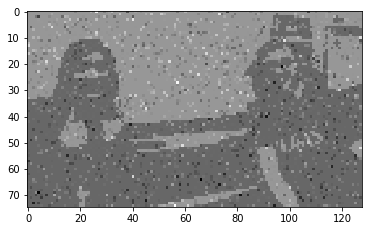

Gaussian


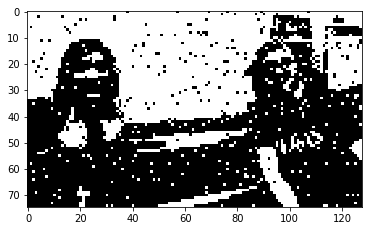

Salt and Pepper


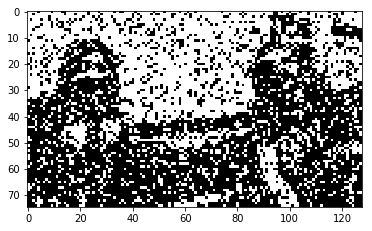



prop: 0.2 	varSigma: 0.7
Original


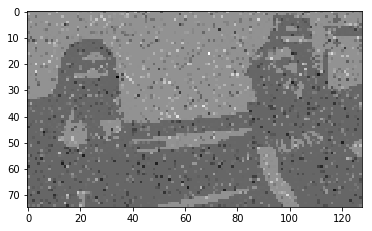

Gaussian


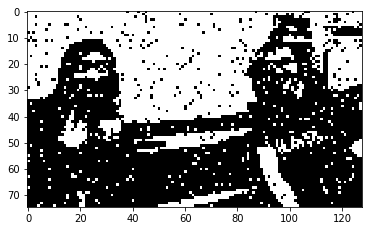

Salt and Pepper


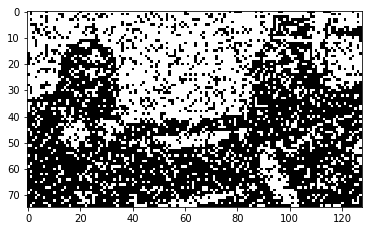



prop: 0.2 	varSigma: 0.8
Original


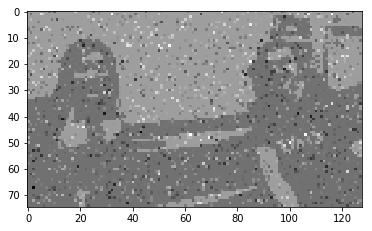

Gaussian


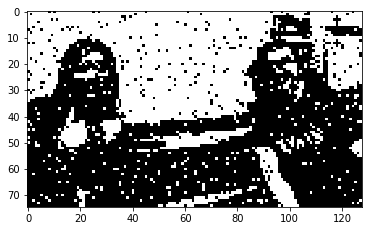

Salt and Pepper


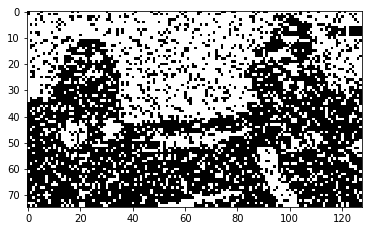



prop: 0.2 	varSigma: 0.9
Original


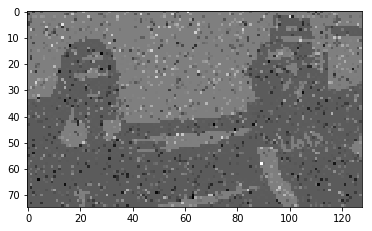

Gaussian


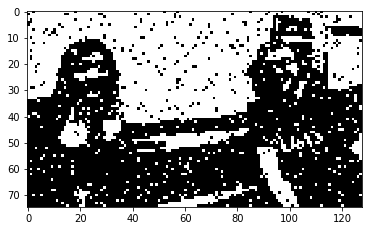

Salt and Pepper


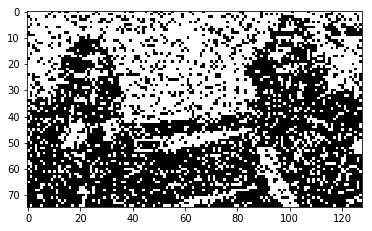



prop: 0.3 	varSigma: 0.0
Original


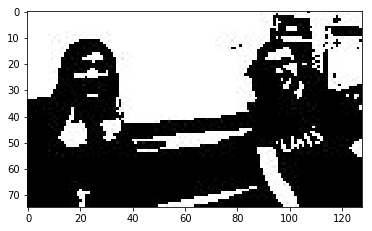

Gaussian


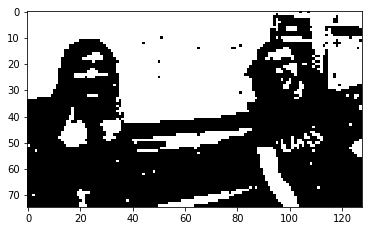

Salt and Pepper


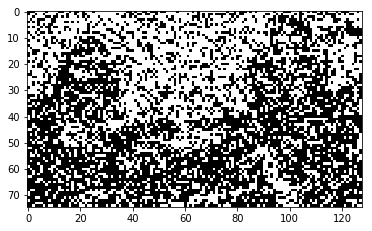



prop: 0.3 	varSigma: 0.1
Original


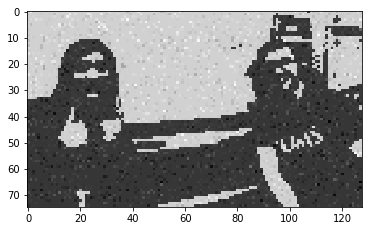

Gaussian


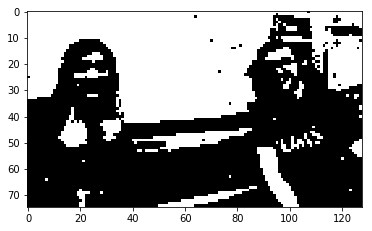

Salt and Pepper


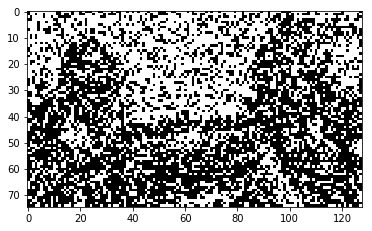



prop: 0.3 	varSigma: 0.2
Original


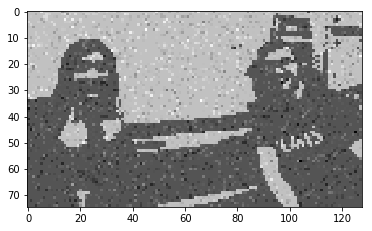

Gaussian


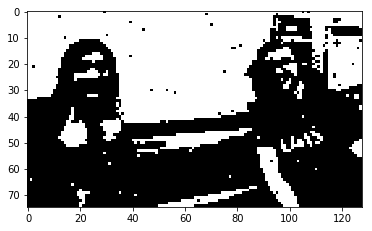

Salt and Pepper


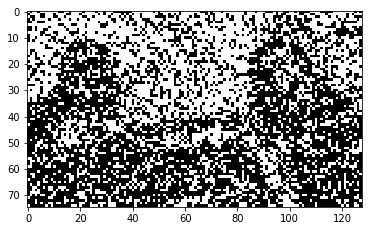



prop: 0.3 	varSigma: 0.3
Original


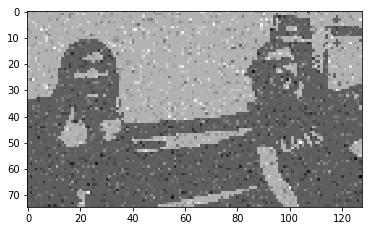

Gaussian


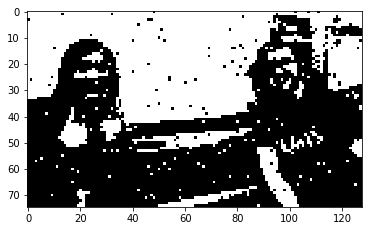

Salt and Pepper


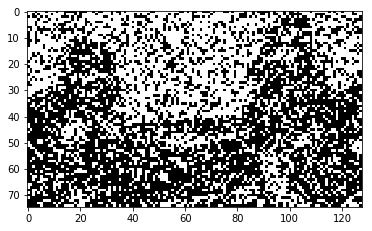



prop: 0.3 	varSigma: 0.4
Original


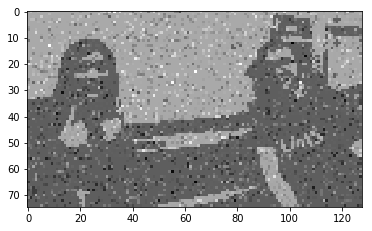

Gaussian


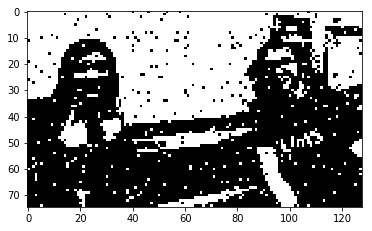

Salt and Pepper


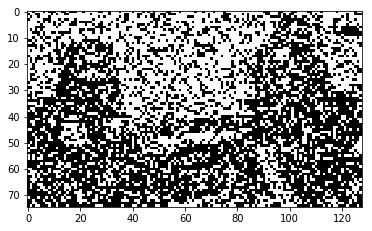



prop: 0.3 	varSigma: 0.5
Original


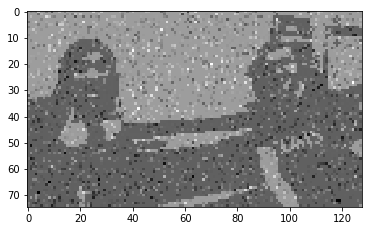

Gaussian


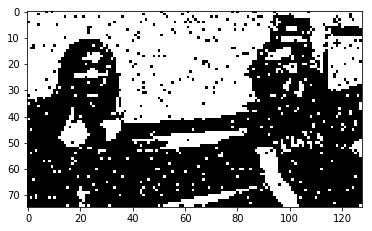

Salt and Pepper


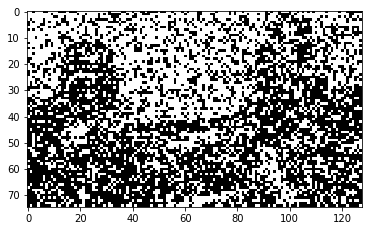



prop: 0.3 	varSigma: 0.6
Original


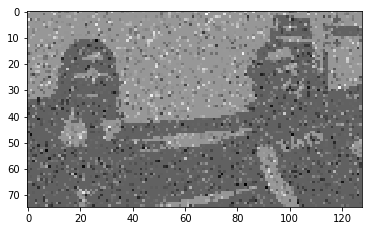

Gaussian


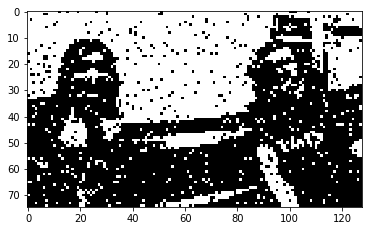

Salt and Pepper


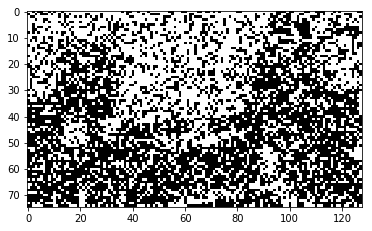



prop: 0.3 	varSigma: 0.7
Original


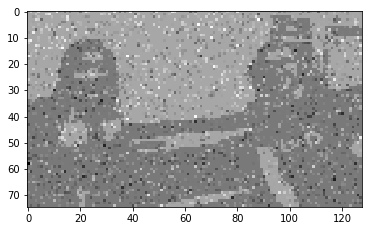

Gaussian


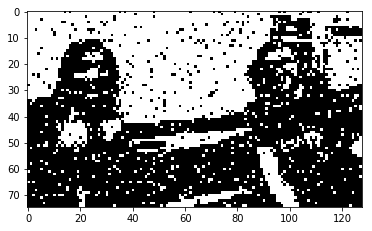

Salt and Pepper


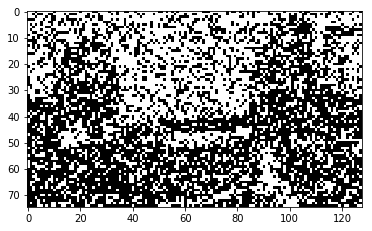



prop: 0.3 	varSigma: 0.8
Original


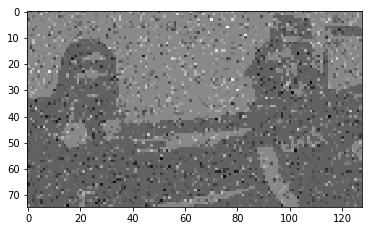

Gaussian


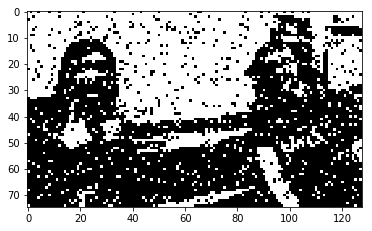

Salt and Pepper


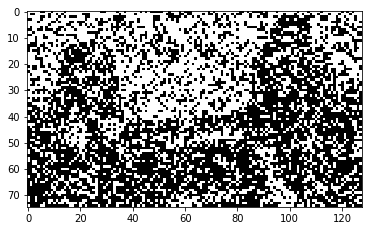



prop: 0.3 	varSigma: 0.9
Original


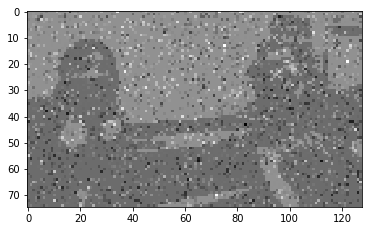

Gaussian


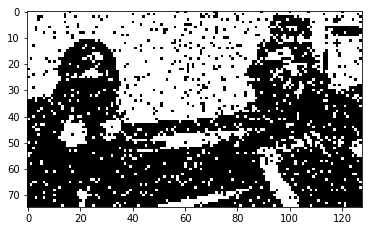

Salt and Pepper


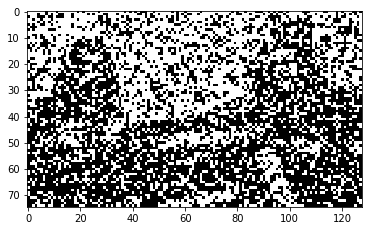



prop: 0.4 	varSigma: 0.0
Original


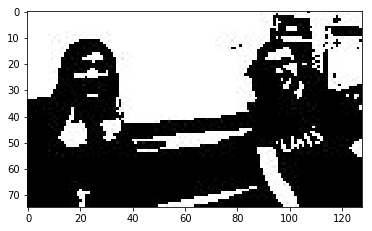

Gaussian


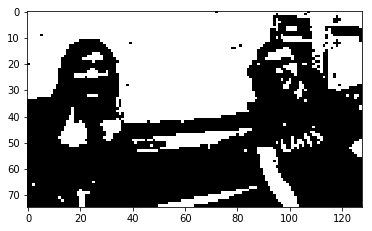

Salt and Pepper


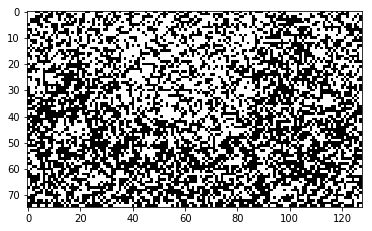



prop: 0.4 	varSigma: 0.1
Original


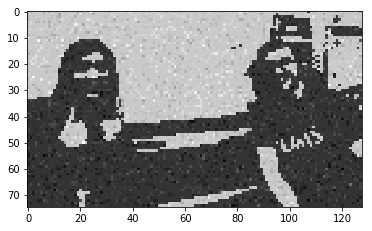

Gaussian


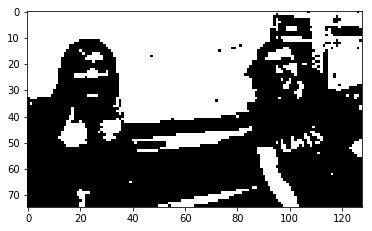

Salt and Pepper


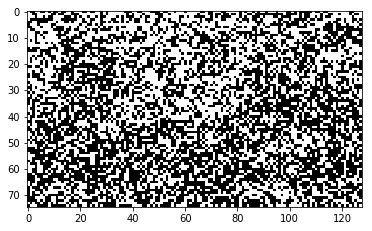



prop: 0.4 	varSigma: 0.2
Original


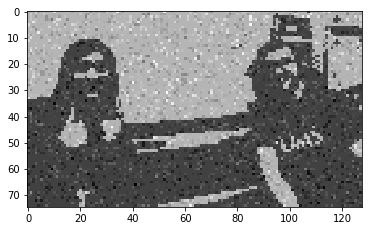

Gaussian


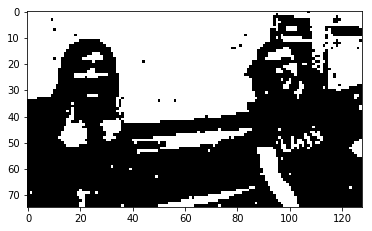

Salt and Pepper


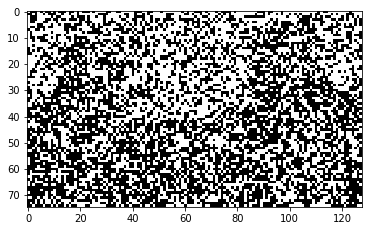



prop: 0.4 	varSigma: 0.3
Original


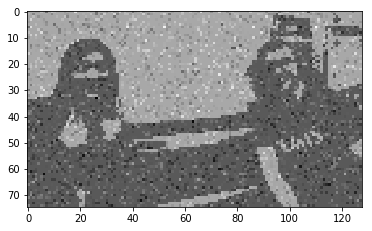

Gaussian


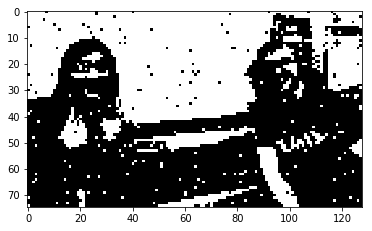

Salt and Pepper


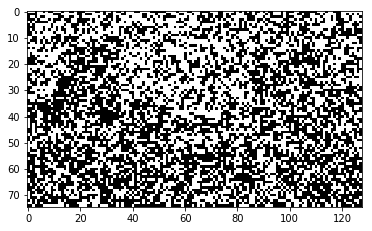



prop: 0.4 	varSigma: 0.4
Original


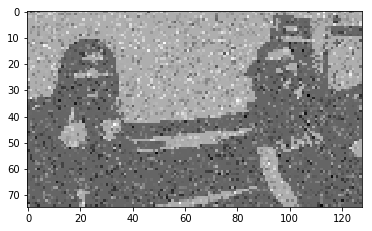

Gaussian


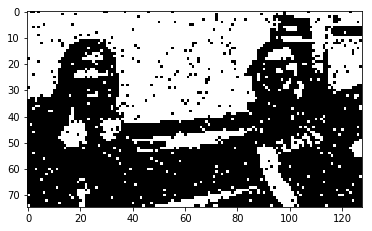

Salt and Pepper


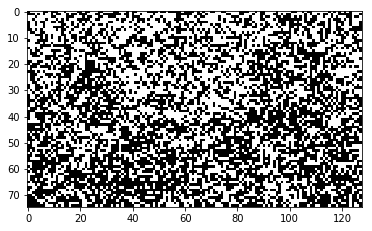



prop: 0.4 	varSigma: 0.5
Original


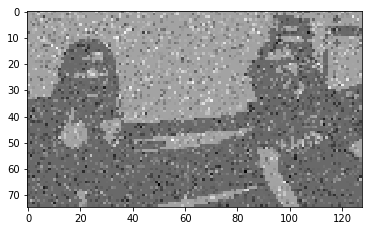

Gaussian


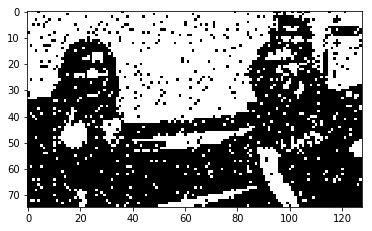

Salt and Pepper


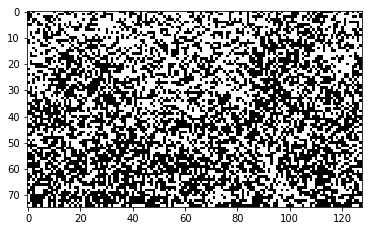



prop: 0.4 	varSigma: 0.6
Original


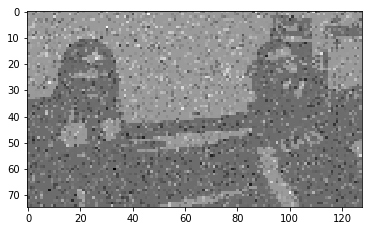

Gaussian


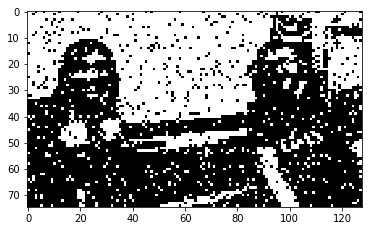

Salt and Pepper


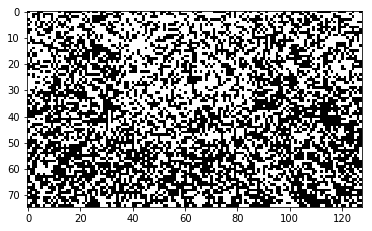



prop: 0.4 	varSigma: 0.7
Original


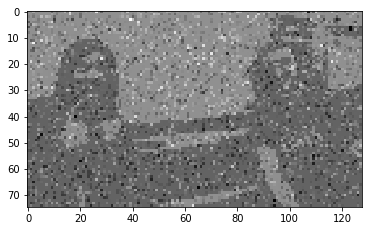

Gaussian


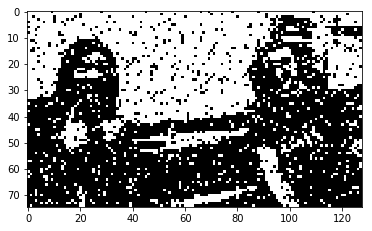

Salt and Pepper


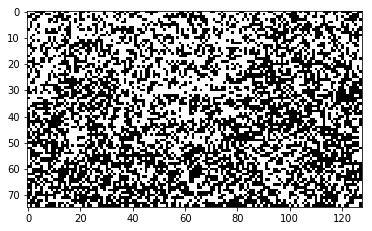



prop: 0.4 	varSigma: 0.8
Original


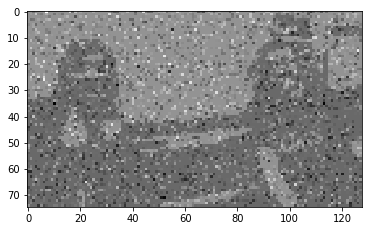

Gaussian


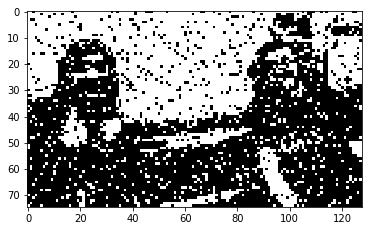

Salt and Pepper


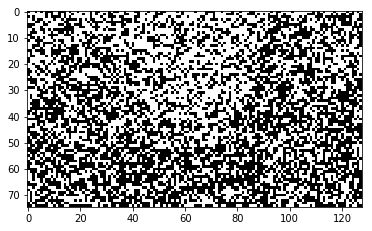



prop: 0.4 	varSigma: 0.9
Original


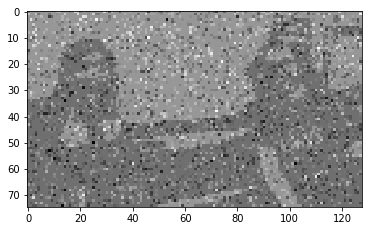

Gaussian


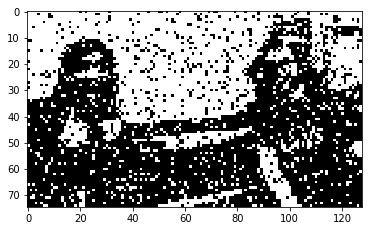

Salt and Pepper


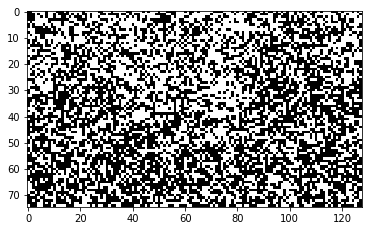



prop: 0.5 	varSigma: 0.0
Original


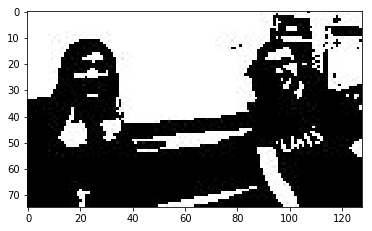

Gaussian


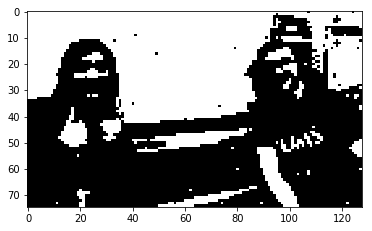

Salt and Pepper


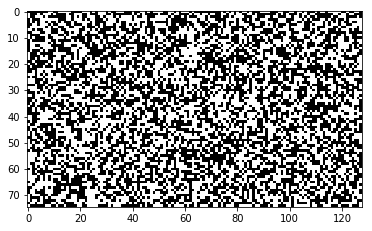



prop: 0.5 	varSigma: 0.1
Original


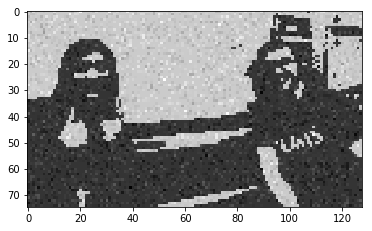

Gaussian


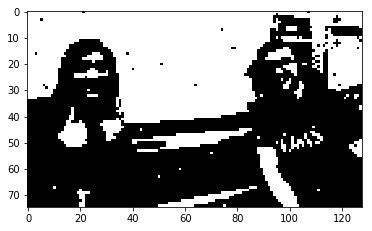

Salt and Pepper


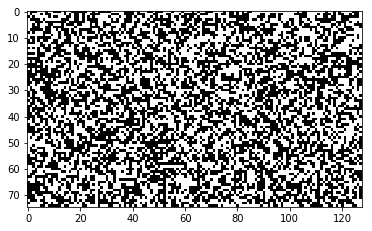



prop: 0.5 	varSigma: 0.2
Original


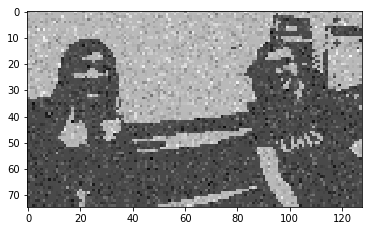

Gaussian


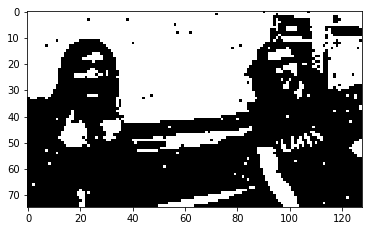

Salt and Pepper


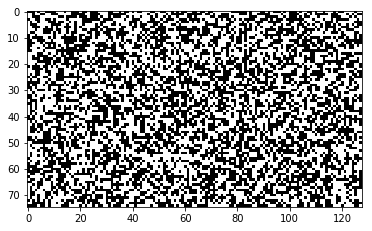



prop: 0.5 	varSigma: 0.3
Original


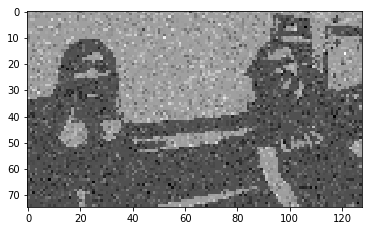

Gaussian


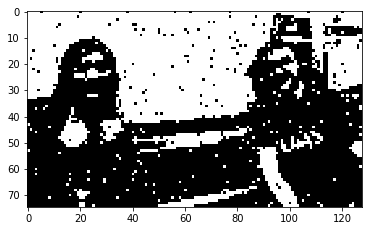

Salt and Pepper


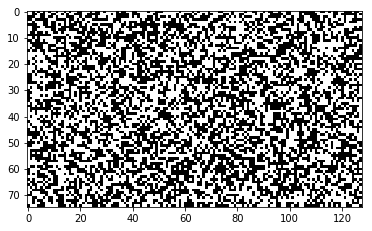



prop: 0.5 	varSigma: 0.4
Original


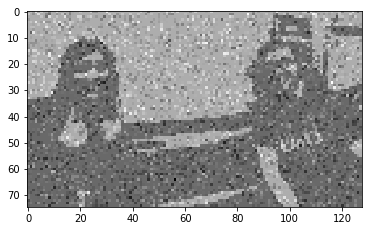

Gaussian


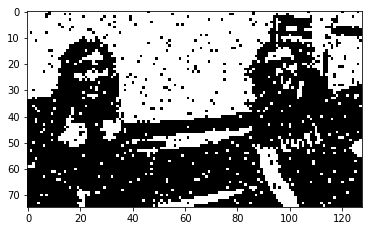

Salt and Pepper


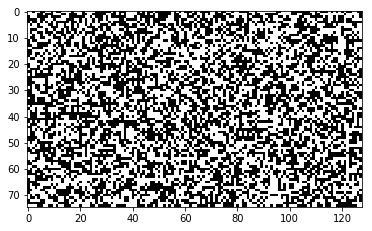



prop: 0.5 	varSigma: 0.5
Original


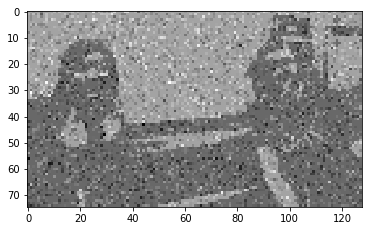

Gaussian


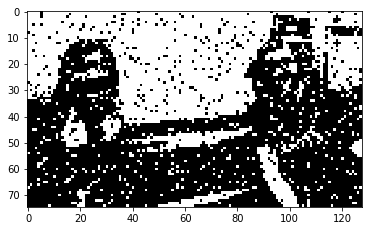

Salt and Pepper


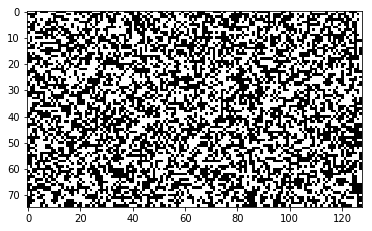



prop: 0.5 	varSigma: 0.6
Original


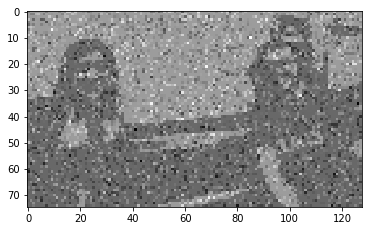

Gaussian


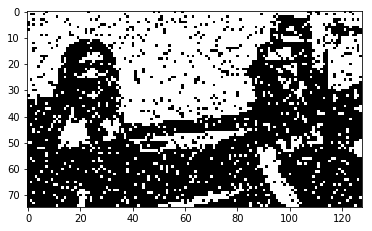

Salt and Pepper


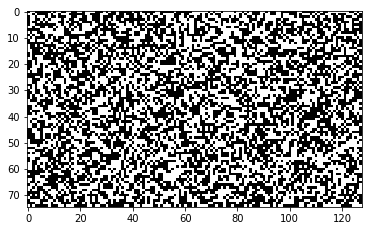



prop: 0.5 	varSigma: 0.7
Original


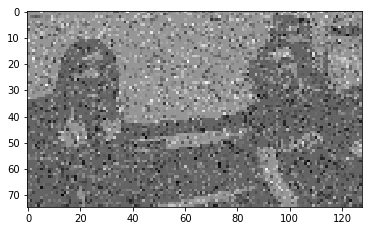

Gaussian


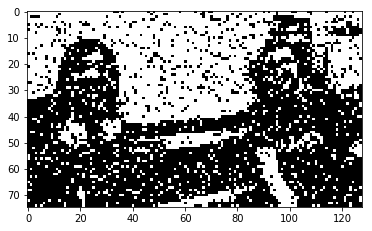

Salt and Pepper


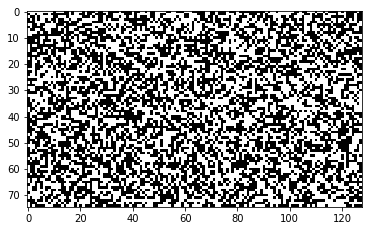



prop: 0.5 	varSigma: 0.8
Original


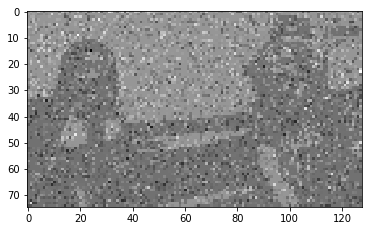

Gaussian


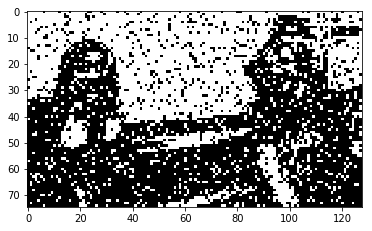

Salt and Pepper


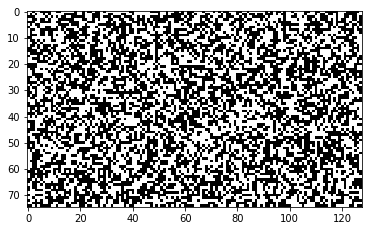



prop: 0.5 	varSigma: 0.9
Original


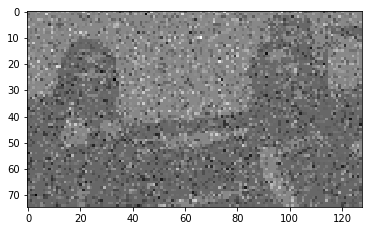

Gaussian


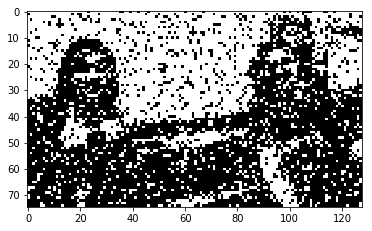

Salt and Pepper


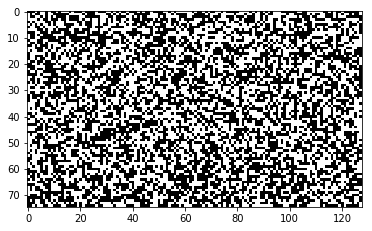



prop: 0.6 	varSigma: 0.0
Original


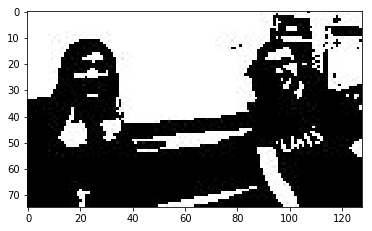

Gaussian


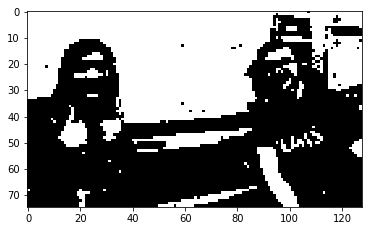

Salt and Pepper


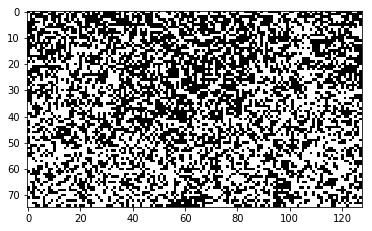



prop: 0.6 	varSigma: 0.1
Original


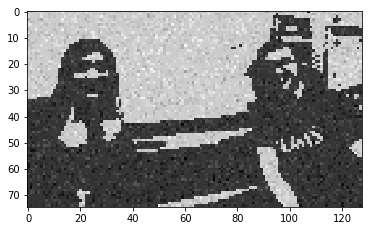

Gaussian


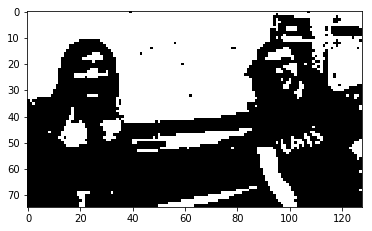

Salt and Pepper


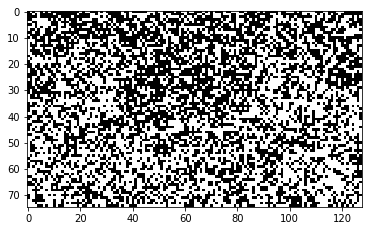



prop: 0.6 	varSigma: 0.2
Original


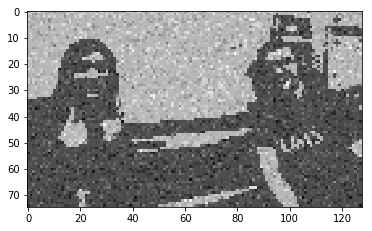

Gaussian


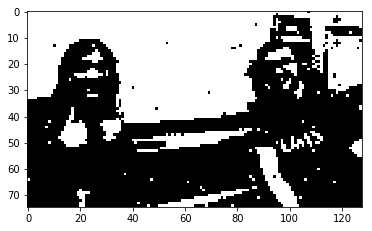

Salt and Pepper


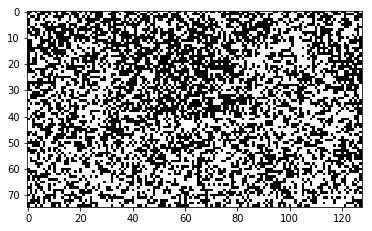



prop: 0.6 	varSigma: 0.3
Original


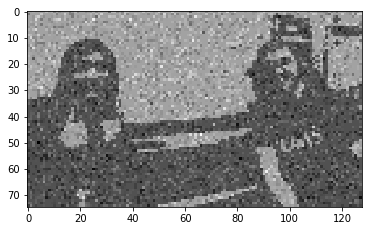

Gaussian


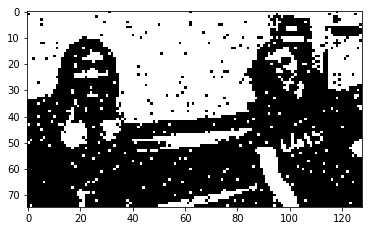

Salt and Pepper


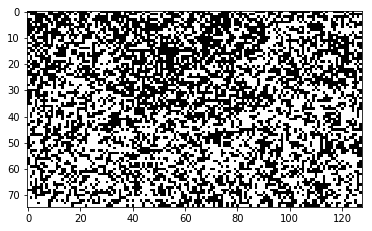



prop: 0.6 	varSigma: 0.4
Original


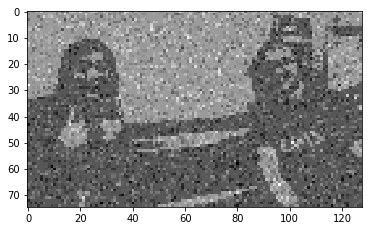

Gaussian


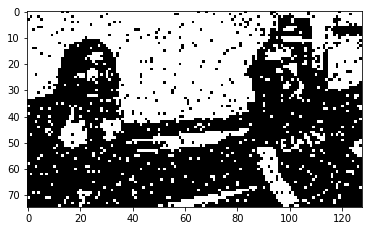

Salt and Pepper


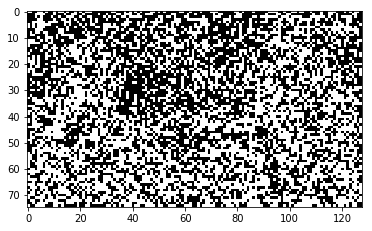



prop: 0.6 	varSigma: 0.5
Original


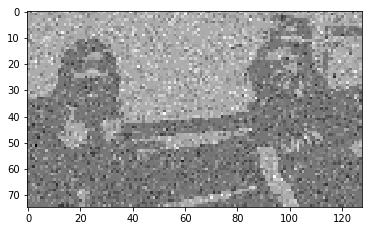

Gaussian


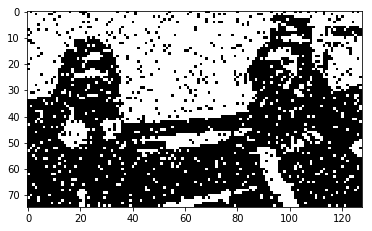

Salt and Pepper


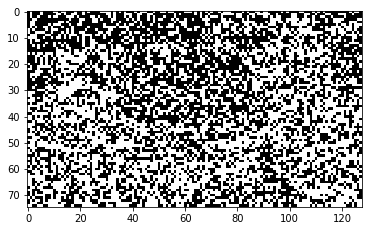



prop: 0.6 	varSigma: 0.6
Original


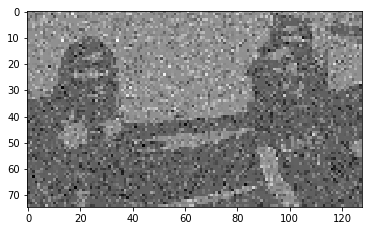

Gaussian


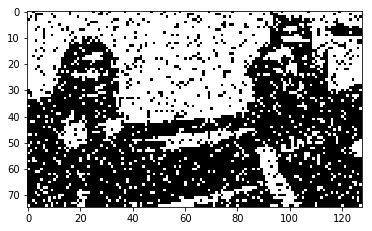

Salt and Pepper


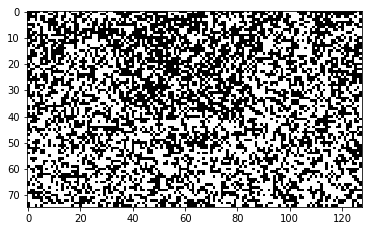



prop: 0.6 	varSigma: 0.7
Original


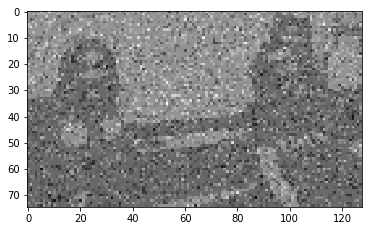

Gaussian


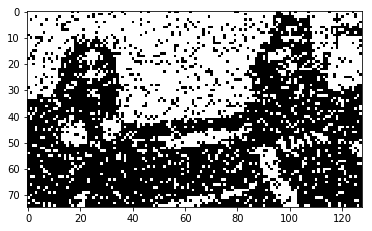

Salt and Pepper


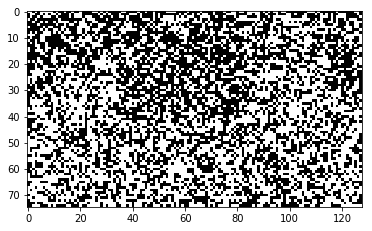



prop: 0.6 	varSigma: 0.8
Original


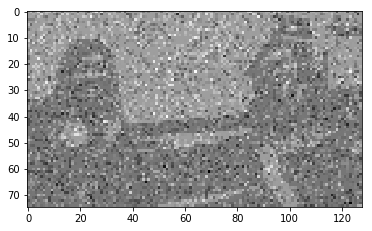

Gaussian


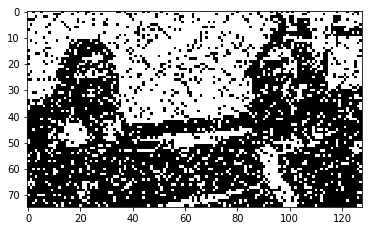

Salt and Pepper


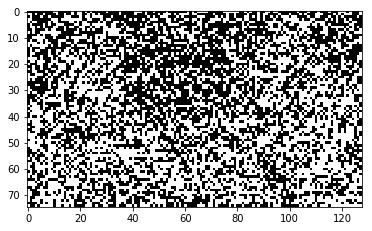



prop: 0.6 	varSigma: 0.9
Original


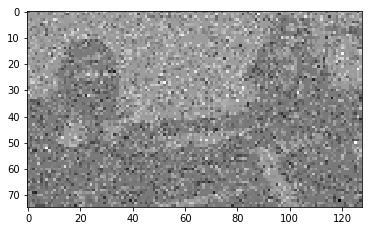

Gaussian


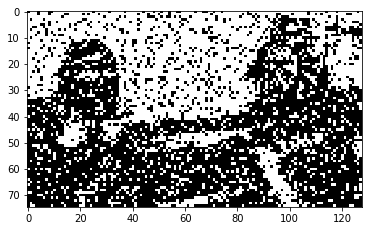

Salt and Pepper


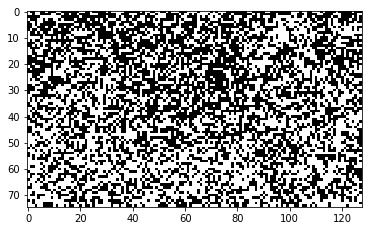



prop: 0.7 	varSigma: 0.0
Original


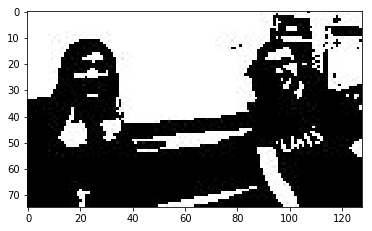

Gaussian


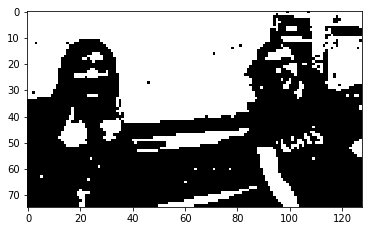

Salt and Pepper


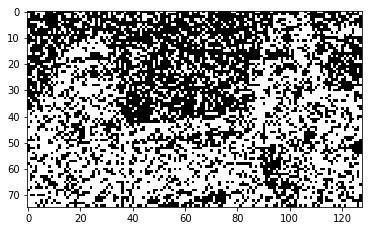



prop: 0.7 	varSigma: 0.1
Original


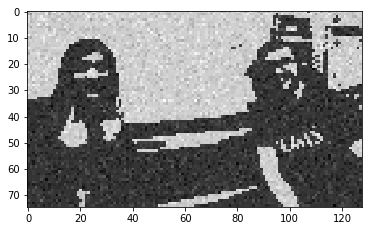

Gaussian


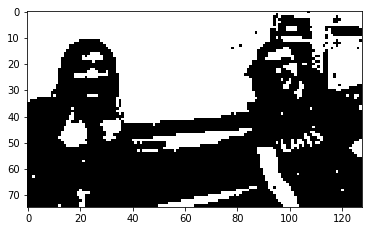

Salt and Pepper


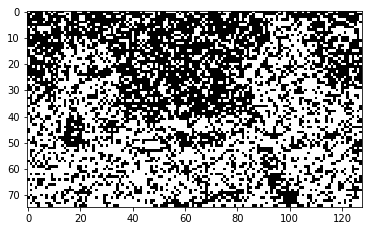



prop: 0.7 	varSigma: 0.2
Original


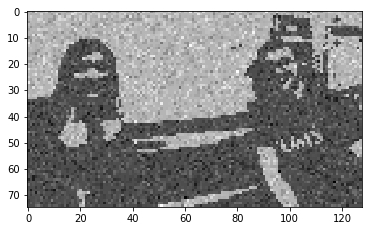

Gaussian


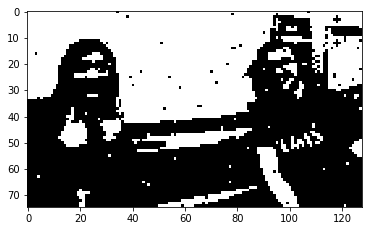

Salt and Pepper


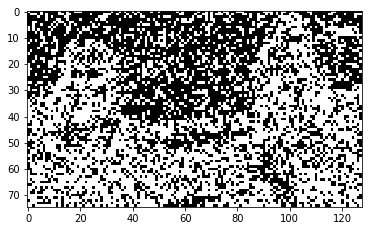



prop: 0.7 	varSigma: 0.3
Original


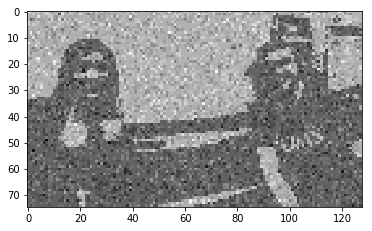

Gaussian


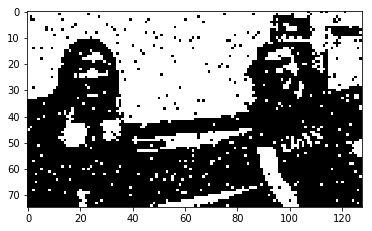

Salt and Pepper


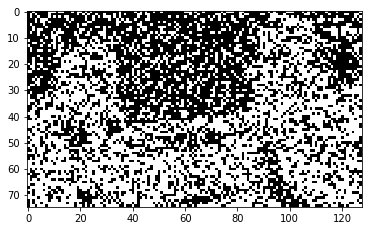



prop: 0.7 	varSigma: 0.4
Original


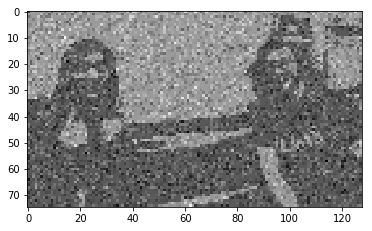

Gaussian


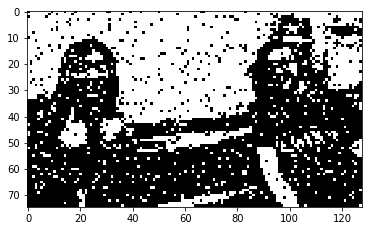

Salt and Pepper


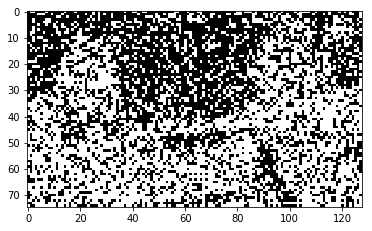



prop: 0.7 	varSigma: 0.5
Original


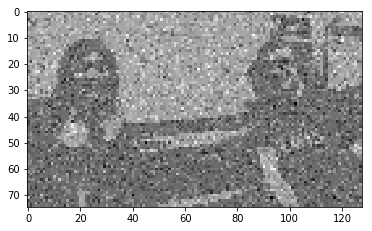

Gaussian


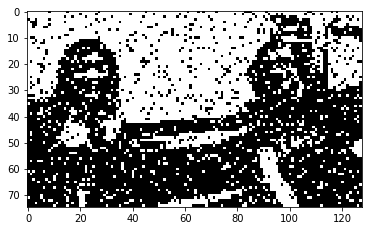

Salt and Pepper


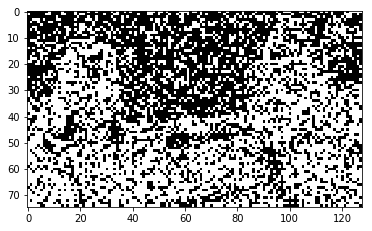



prop: 0.7 	varSigma: 0.6
Original


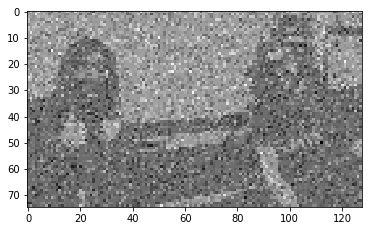

Gaussian


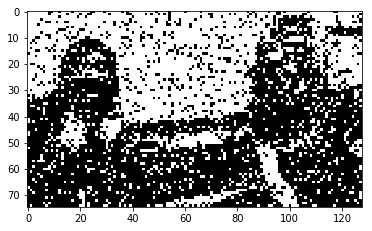

Salt and Pepper


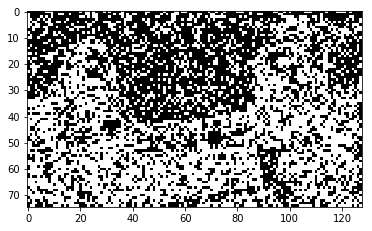



prop: 0.7 	varSigma: 0.7
Original


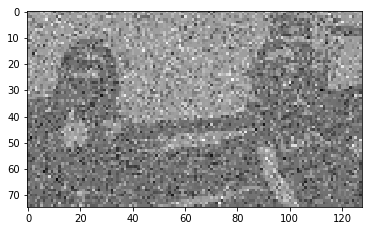

Gaussian


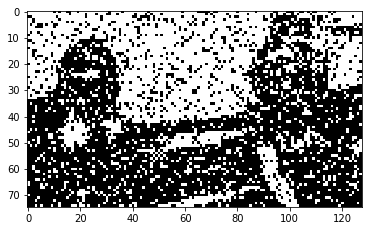

Salt and Pepper


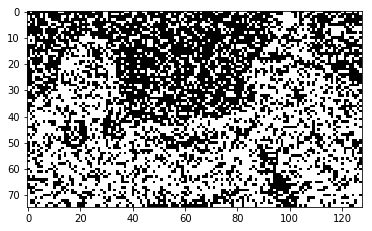



prop: 0.7 	varSigma: 0.8
Original


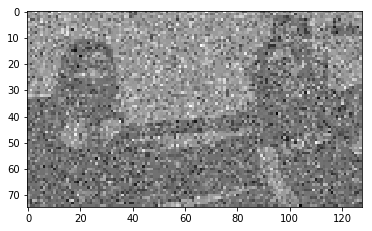

Gaussian


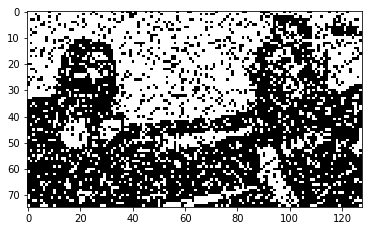

Salt and Pepper


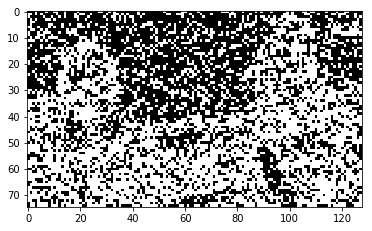



prop: 0.7 	varSigma: 0.9
Original


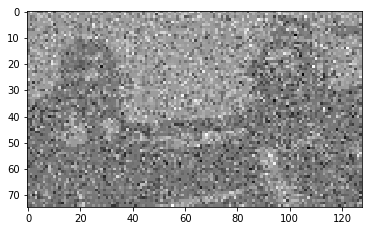

Gaussian


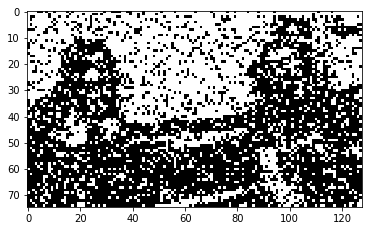

Salt and Pepper


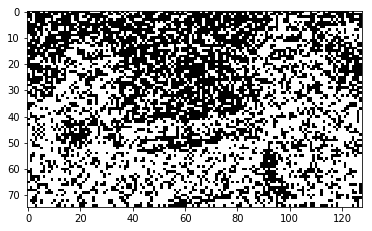



prop: 0.8 	varSigma: 0.0
Original


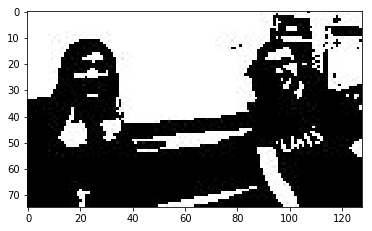

Gaussian


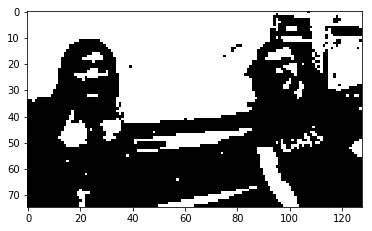

Salt and Pepper


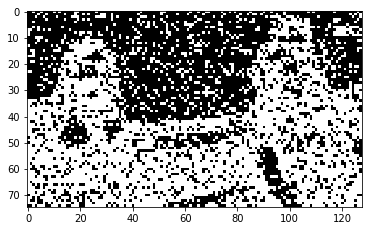



prop: 0.8 	varSigma: 0.1
Original


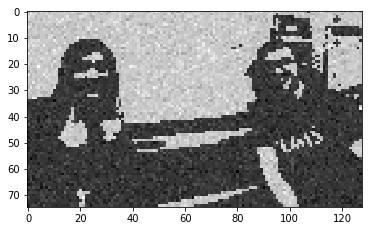

Gaussian


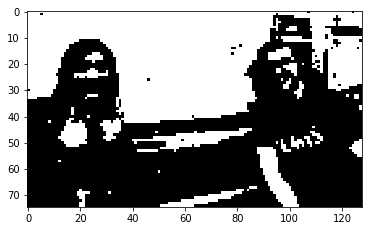

Salt and Pepper


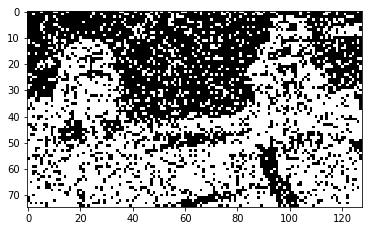



prop: 0.8 	varSigma: 0.2
Original


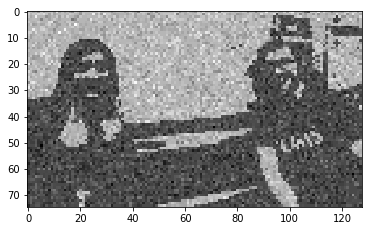

Gaussian


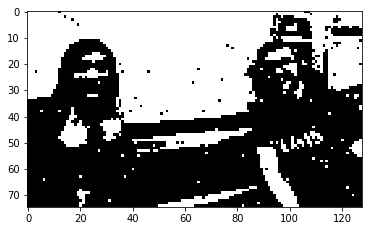

Salt and Pepper


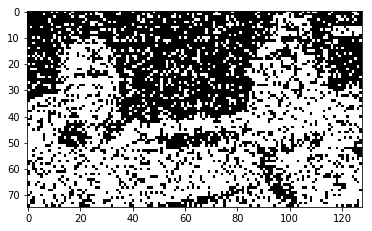



prop: 0.8 	varSigma: 0.3
Original


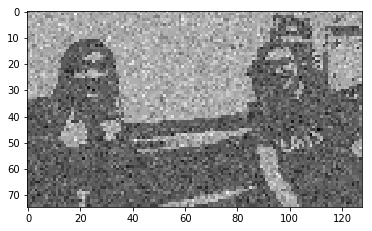

Gaussian


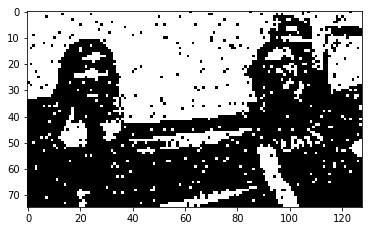

Salt and Pepper


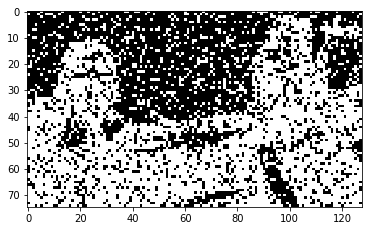



prop: 0.8 	varSigma: 0.4
Original


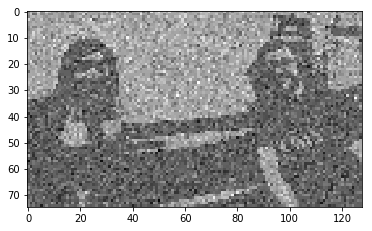

Gaussian


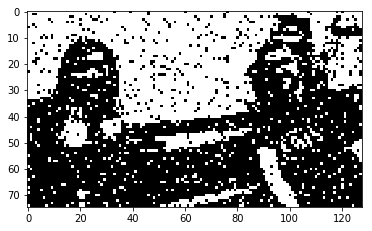

Salt and Pepper


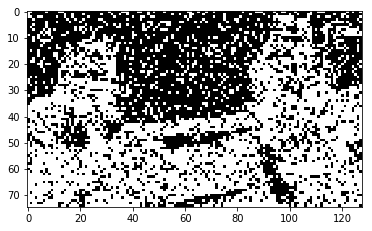



prop: 0.8 	varSigma: 0.5
Original


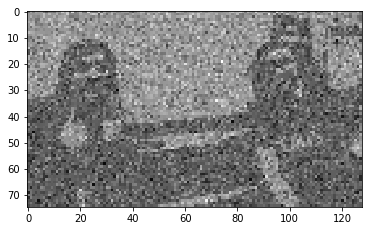

Gaussian


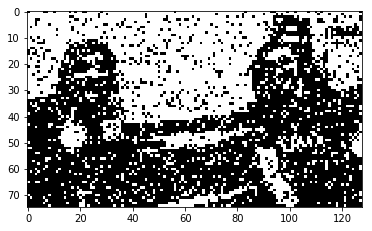

Salt and Pepper


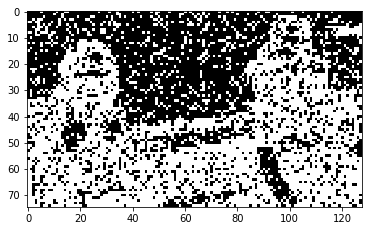



prop: 0.8 	varSigma: 0.6
Original


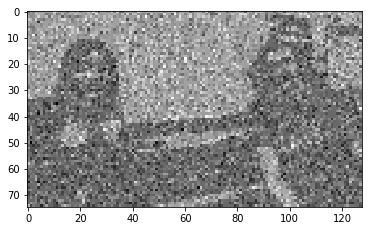

Gaussian


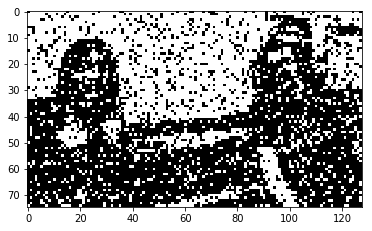

Salt and Pepper


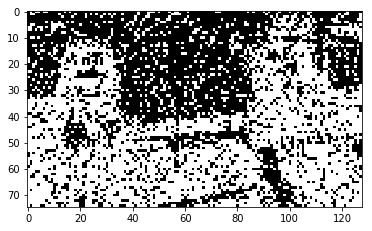



prop: 0.8 	varSigma: 0.7
Original


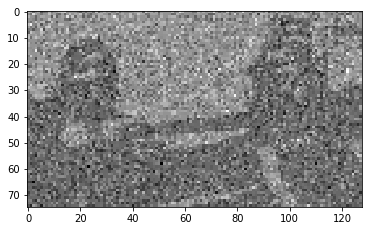

Gaussian


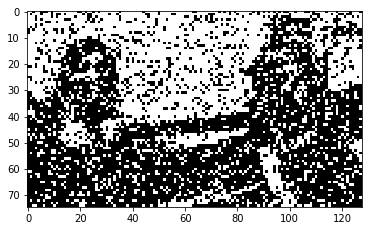

Salt and Pepper


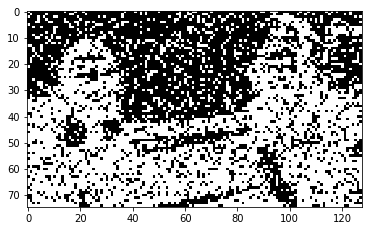



prop: 0.8 	varSigma: 0.8
Original


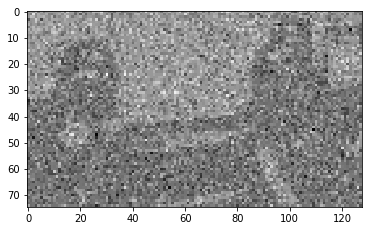

Gaussian


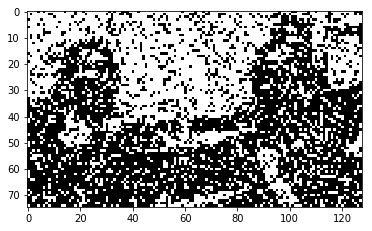

Salt and Pepper


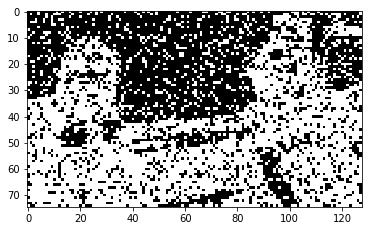



prop: 0.8 	varSigma: 0.9
Original


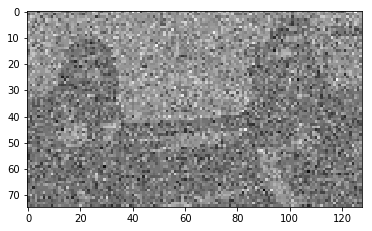

Gaussian


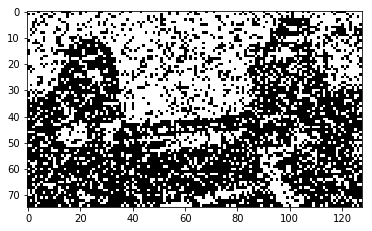

Salt and Pepper


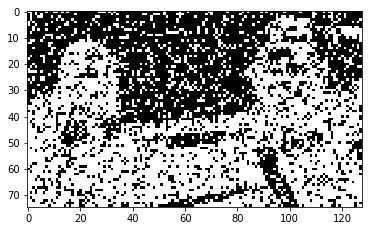



prop: 0.9 	varSigma: 0.0
Original


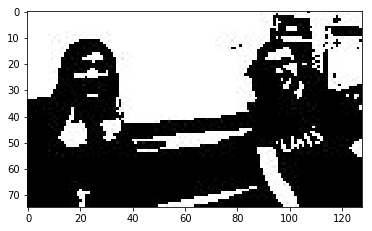

Gaussian


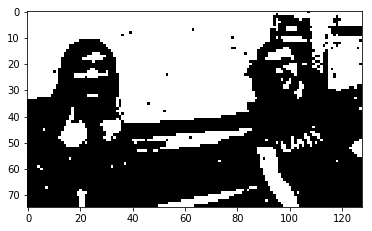

Salt and Pepper


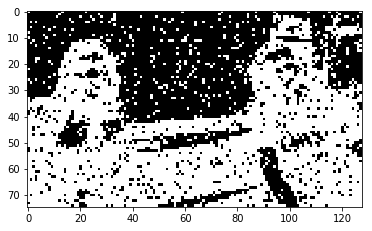



prop: 0.9 	varSigma: 0.1
Original


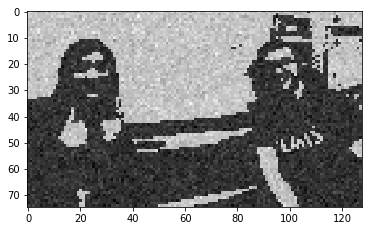

Gaussian


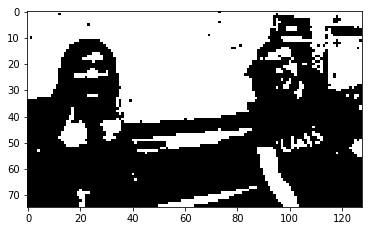

Salt and Pepper


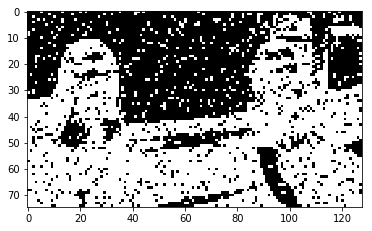



prop: 0.9 	varSigma: 0.2
Original


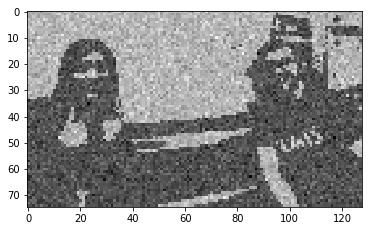

Gaussian


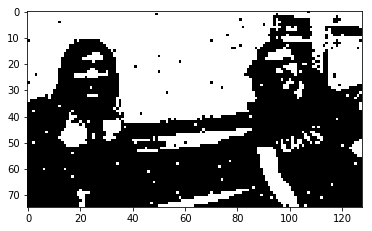

Salt and Pepper


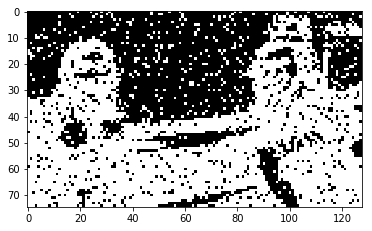



prop: 0.9 	varSigma: 0.3
Original


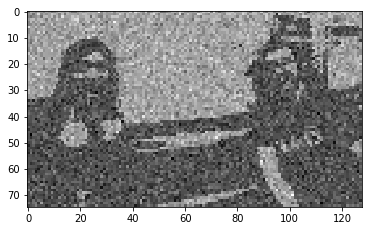

Gaussian


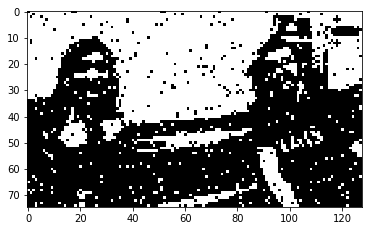

Salt and Pepper


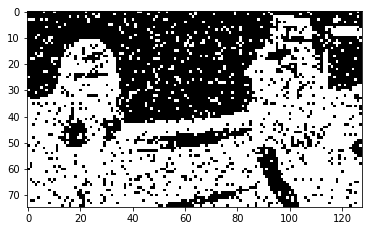



prop: 0.9 	varSigma: 0.4
Original


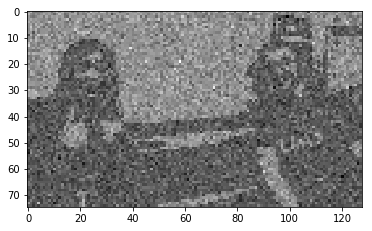

Gaussian


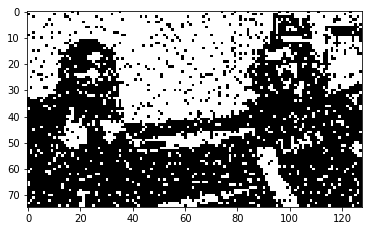

Salt and Pepper


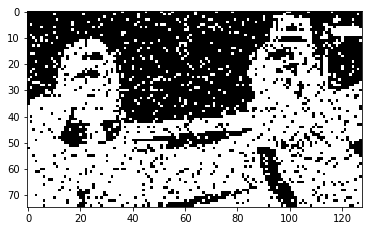



prop: 0.9 	varSigma: 0.5
Original


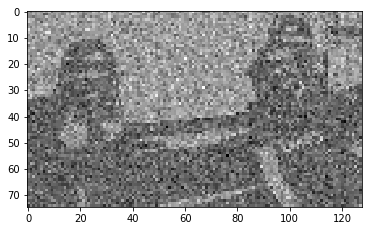

Gaussian


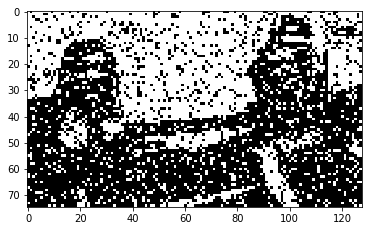

Salt and Pepper


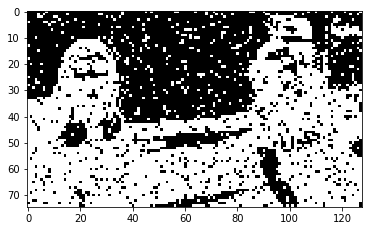



prop: 0.9 	varSigma: 0.6
Original


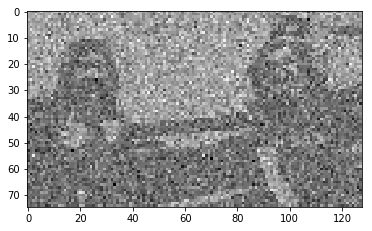

Gaussian


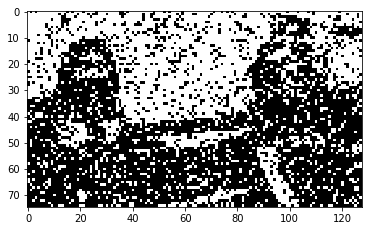

Salt and Pepper


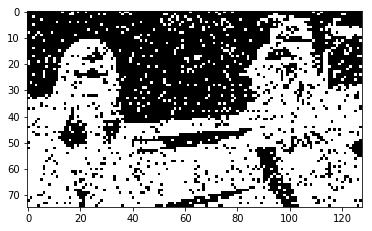



prop: 0.9 	varSigma: 0.7
Original


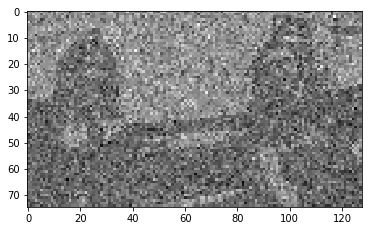

Gaussian


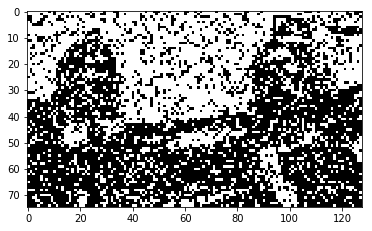

Salt and Pepper


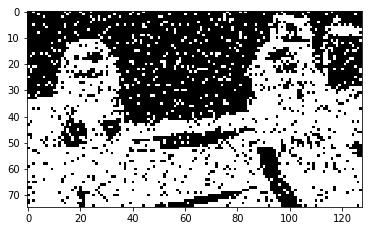



prop: 0.9 	varSigma: 0.8
Original


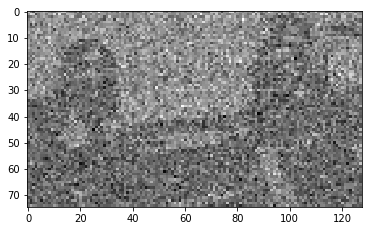

Gaussian


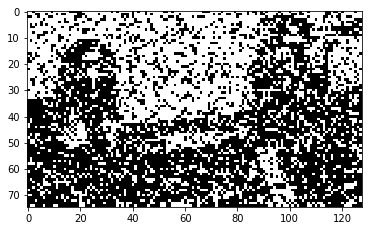

Salt and Pepper


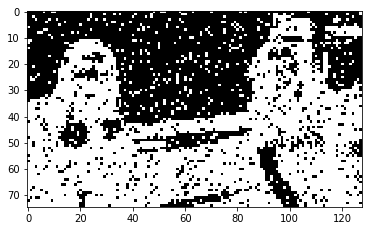



prop: 0.9 	varSigma: 0.9
Original


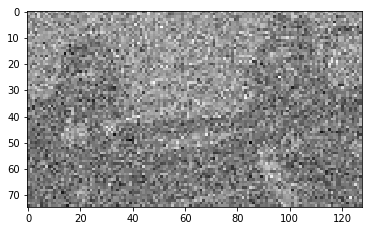

Gaussian


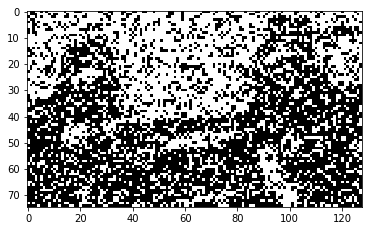

Salt and Pepper


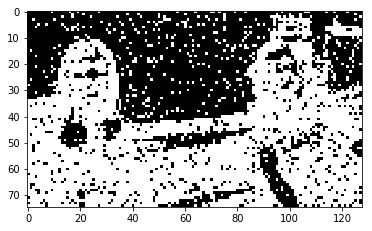

In [17]:
# Gibbs Tests
for i in range(len(gaussianImgs)):
    gibbsGauss = Gibbs(gaussianImgs[i][0])
    gibbsSnp = Gibbs(snpImgs[i][0])
    
    gaussOutput = gibbsGauss.runGibbsLoop(20)
    snpOutput = gibbsSnp.runGibbsLoop(20)
    
    print("prop:", gaussianImgs[i][1], "\tvarSigma:", gaussianImgs[i][2])
    print("Original")
    plt.imshow(gaussianImgs[i][0], cmap="gray")
    plt.show()
    plt.imshow(snpImgs[i][0], cmap="gray")
    print("Gaussian")
    plt.imshow(gaussOutput, cmap="gray")
    plt.show()
    print("Salt and Pepper")
    plt.imshow(snpOutput, cmap="gray")
    plt.show()
    print("\n")

In [43]:
gibbsRandGauss = Gibbs(gaussianImg)
gibbsRandOutput = gibbsRandGauss.runGibbsLoop(1, True, 1000)
plt.imshow(gibbsRandOutput, cmap="gray")
plt.show()

Finished randomising samples


TypeError: append() takes exactly one argument (2 given)

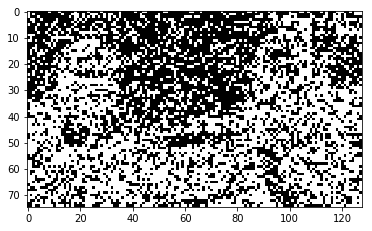

In [26]:
gibbsSNP = Gibbs(snpImg)
gibbsSNPOutput = gibbsSNP.runGibbsLoop(10)
plt.imshow(gibbsSNPOutput, cmap="gray")
plt.show()


In [15]:
gibbsRandSNP = Gibbs(snpImg)
gibbsRandSNPOutput = gibbsRandSNP.runGibbsLoop(100, True, 100)
plt.imshow(gibbsRandSNPOutput, cmap="gray")
plt.show()

KeyboardInterrupt: 

In [ ]:
gibbsRandSNP = Gibbs(snpImg)
gibbsRandSNPOutput = gibbsRandSNP.runGibbsLoop(100, True, 200)
plt.imshow(gibbsRandSNPOutput, cmap="gray")
plt.show()

In [12]:
class VariBay(object):
    def __init__(self, image):
        # Rounds values in the y image to be 0 and 1
        self.image = (image > 0.5).astype(float)
        
        #Stuff to help calculate loops and neighbours
        self.T = image.shape[0] #cols 75
        self.N = image.shape[1] #rows 128
        self.helper = HelperTools()
        
        # Set x to be the image and both images. Convert zeroes to -1s.
        self.x = self.image + (self.image - 1)
        self.image = self.image + (self.image -1)
        
        #initialise mu
        self.mu = self.image
        self.tempMu = self.image
        
    def lixi(self, x, t, i):
        """Returns 2.1 if values are the same, -2.1 otherwise"""
        cons = 2.1
        return cons * x * self.image[t][i]
    
    def computeM(self, t, i):
        ni = self.helper.neighbours(t, i, self.T, self.N, 8)
        w = 1/8
        m = 0
        for n in ni:
            m += w*self.mu[n[0]][n[1]]
        return m
    
    def findMU(self, m, t, i):
        mu = np.tanh((m + 0.5*(self.lixi(1, t, i) - self.lixi(-1, t, i))))
        return mu
    
    def variBayLoop(self, iterations=100):
        for tau in range(iterations):
            for t in range(self.T):
                for i in range(self.N):
                    m = self.computeM(t, i)
                    self.tempMu[t][i] = self.findMU(m, t, i)
                self.mu = self.tempMu    
                
        for t in range(self.T):
            for i in range(self.N):
                self.mu[t][i] = int(round(self.mu[t][i]))
        return self.mu
                    
        

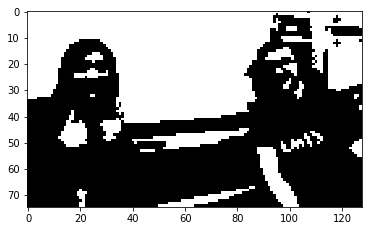

In [13]:
variBayObj = VariBay(gaussianImg)
variBayImg = variBayObj.variBayLoop(10)
plt.imshow(variBayImg, cmap="gray")
plt.show()